In [1]:
# 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os  # 디렉토리 변경

from IPython.display import Image

from sklearn.cluster import KMeans

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

os.chdir('/content/drive/MyDrive/dataSience/energy/data/') 

In [2]:
# 컬럼명 변환을 위한 리스트 할당
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [3]:
# 데이터 로드
train=pd.read_csv('train.csv', encoding='euc-kr')
test=pd.read_csv('test.csv', encoding='euc-kr')
submission=pd.read_csv('sample_submission.csv', encoding='euc-kr')

In [4]:
# 전처리, 시간 변수 추가
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    
    return train

In [5]:
train = make_time(train)
test = make_time(test)

In [6]:
# 6월 6일은 현충일, 8월 15일은 광복절, 8월 17일은 임시공휴일
# 휴일이 많지 않으니, 주말에 포함

train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[train.weekday < 5, 'holiday'] = 0
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = 1

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0

In [7]:
train['holiday']=train['holiday'].astype(int)
test['holiday']=test['holiday'].astype(int)

In [8]:
test.head()

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN,8,25,0,1,238,0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,1,1,238,0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,2,1,238,0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN,8,25,3,1,238,0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,4,1,238,0


In [9]:
# 결측지 보간
# test에 cooler와 solar를 넣어준다
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [10]:
# test set의 빈 값을 채워줌.
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [11]:
train.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,6,1,0,0,153,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,6,1,1,0,153,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,6,1,2,0,153,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,6,1,3,0,153,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,6,1,4,0,153,0


In [12]:
test.head()

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0
1,1,2020-08-25 01:00:00,27.6,1.4,75.3,0.0,0.0,0.0,0.0,8,25,1,1,238,0
2,1,2020-08-25 02:00:00,27.5,1.2,76.7,0.0,0.0,0.0,0.0,8,25,2,1,238,0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,0
4,1,2020-08-25 04:00:00,26.9,1.2,79.7,0.0,0.0,0.0,0.0,8,25,4,1,238,0


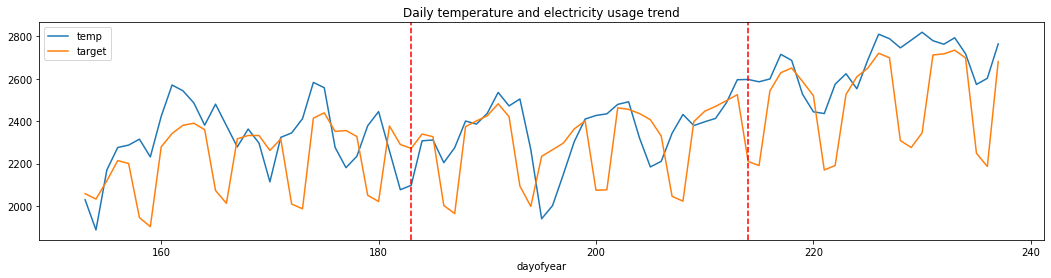

In [13]:
# 평균 기온과 전력 사용량의 그래프
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('Daily temperature and electricity usage trend')
plt.show()

일간 평균 기온과 전력 사용량을 6, 7, 8월로 구분한 플롯입니다.
7월 초순이 끝날 무렵 바닥을 쳤다가, 그 이후로 꾸준히 상승하는 경향을 보입니다.
일반적으로 전력 사용량은 기온과 비슷한 흐름으로 흘러갑니다.

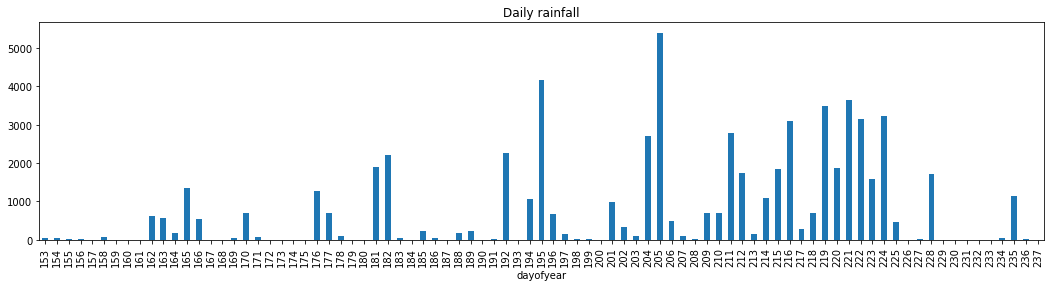

In [14]:
(train.groupby(['dayofyear'])['rain'].sum()).plot(kind='bar', figsize=(18, 4))
plt.title('Daily rainfall')
plt.show()

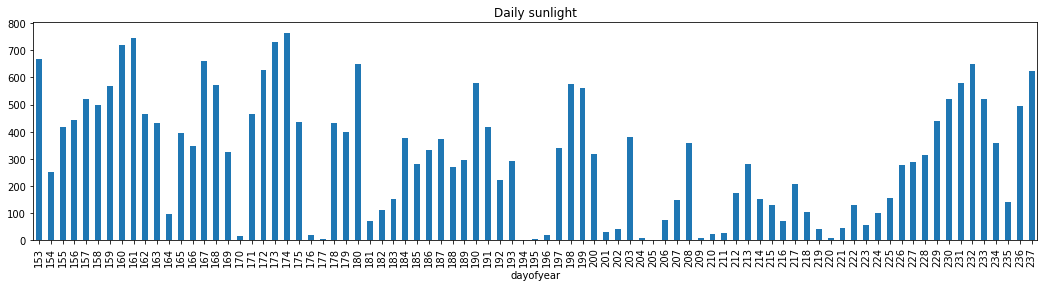

In [15]:
train.groupby(['dayofyear'])['sunny'].sum().plot(kind='bar', figsize=(18, 4))
plt.title('Daily sunlight')
plt.show()

6월, 7월보다 8월 말로 갈수록 더욱 기온은 높아집니다.
기온이 높아짐에 따라 전력 사용량도 같이 높아지는 경향을 보입니다.
7월 말부터 장마의 영향을 받으며 비내리는 날이 많아집니다.
8월 말에는 장마가 끝나며, 비가 오는 날이 거의 없습니다.
일조 시간은 6월에 가장 높았고, 장마 시즌에 줄어들었으며, 8월에 다시 오르고 있습니다.


# 2.1 건물별 전력 사용 패턴 분석

In [16]:
train_origin = train.copy()

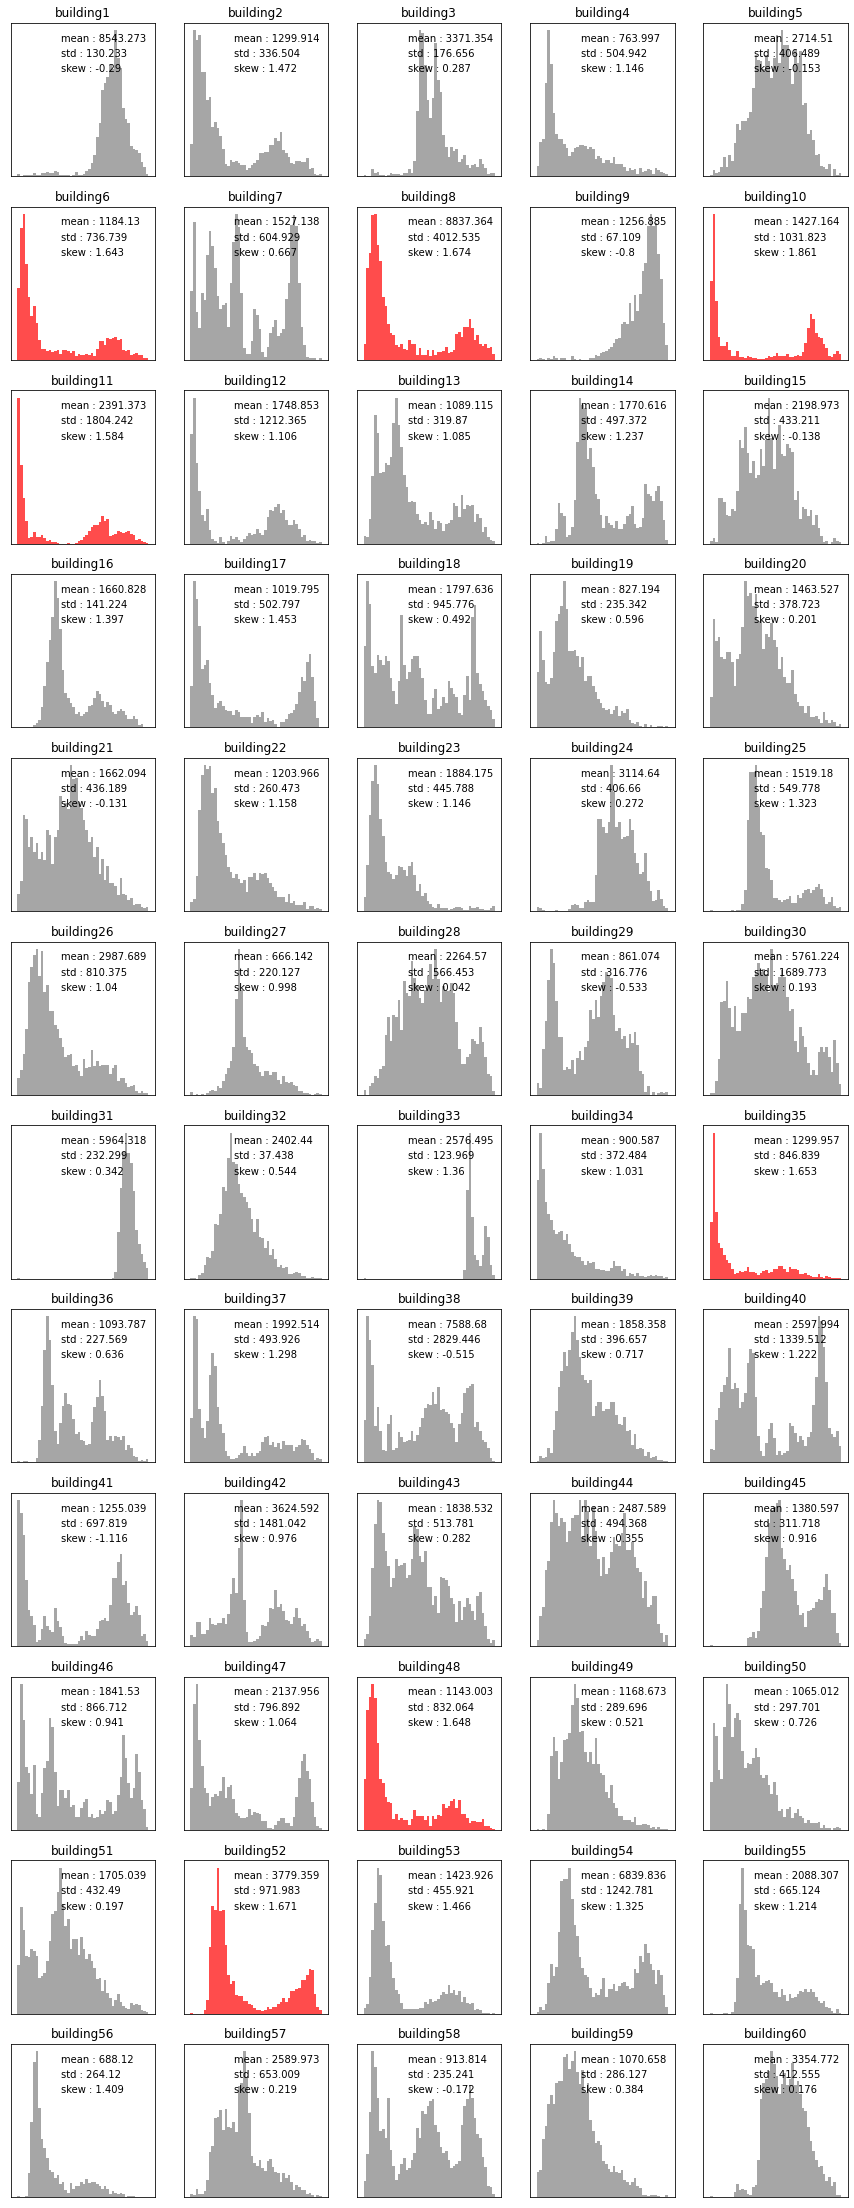

In [17]:
# Target Distribution
fig = plt.figure(figsize = (15, 40))
for num in range(1,61):
    ax = plt.subplot(12, 5, num)
    energy = train_origin.loc[train_origin.num == num, 'target'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

*   건물 별 전력 사용량 분포가 매우 다름
*   다소 편향성이 큰 건물(10, 11, 35, 48, 52 등)도 존재하지만, -2와 2를 넘지는 않음 





# 시간, 요일에 따른 분석

In [18]:
# 정확한 군집화를 위한 스케일링
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean()
    std_ = train.loc[train.num == i].target.std()
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [19]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [20]:
# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [21]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [22]:
# 보기 편하게 컬럼 이름 지정
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

cl_df.columns = columns

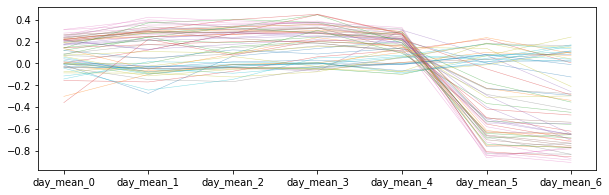

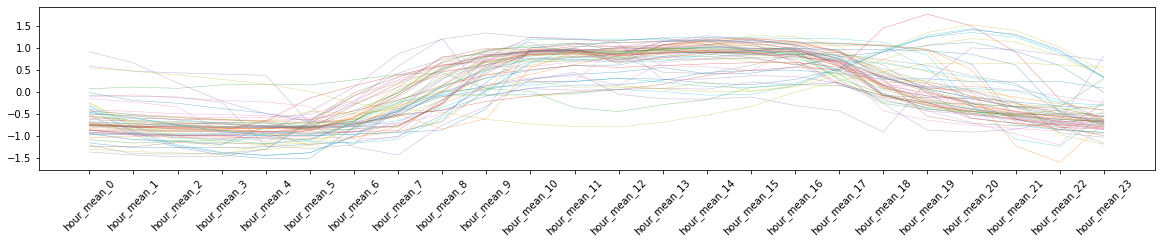

In [23]:
# 시각화를 통한 확인
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

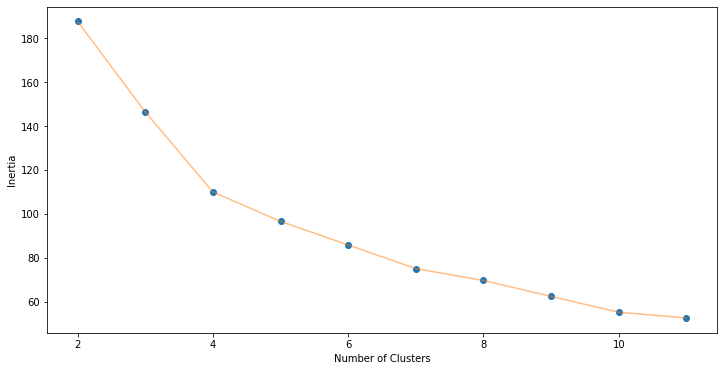

In [24]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

In [25]:
# 엘보우 포인트를 통해 kmeans 클러스터링, k= 4로 결정
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [26]:
# 값 할당
cl_df['km_cluster'] = pred

In [27]:
# 기존 train set과 merge
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [28]:
test_cl = test.copy()

In [29]:
# test set에도 클러스터 값 할당
for i in range(1, 61):
    test_cl.loc[test_cl.num == i, 'km_cluster'] = (
        train_cl.loc[train_cl.num == i, 'km_cluster'].max()
    )

In [30]:
# 군집별 분석을 위한 4개의 데이터셋 할당
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

In [31]:
# 군집별 건물 수
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

,num
km_cluster,
0,7.0
1,33.0
2,5.0
3,15.0


군집별로 건물 살펴보기

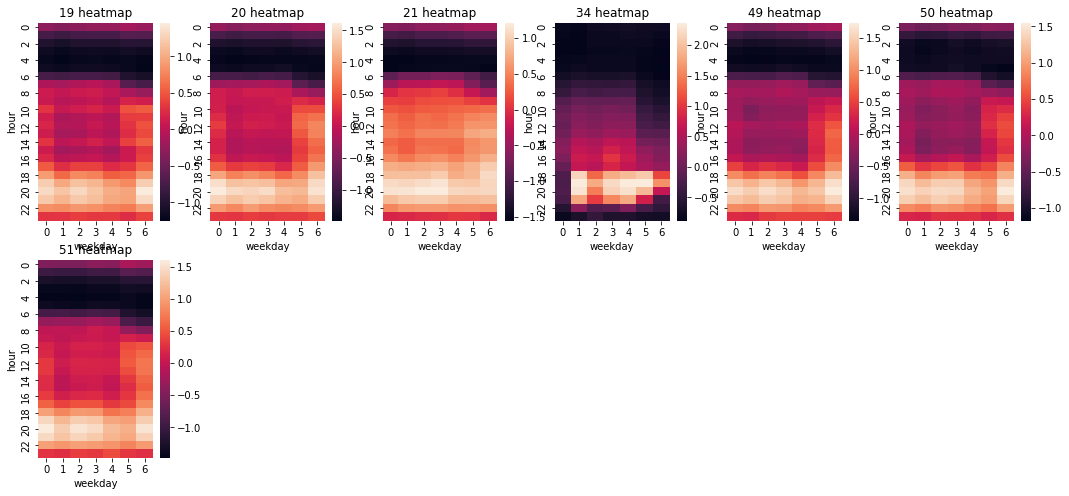

In [32]:
# 0번 cluster
# 평일 낮에는 사용량이 낮은 편이며, 평일 밤과 주말 동안 전력사용량이 증가
# 자정까지 전력사용량이 이어지는 것으로 보아 밤 늦게까지 전력을 사용하는 건물유형. 유흥시설?


fig = plt.figure(figsize=(18, np.ceil(len(km_0)/6)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/6), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

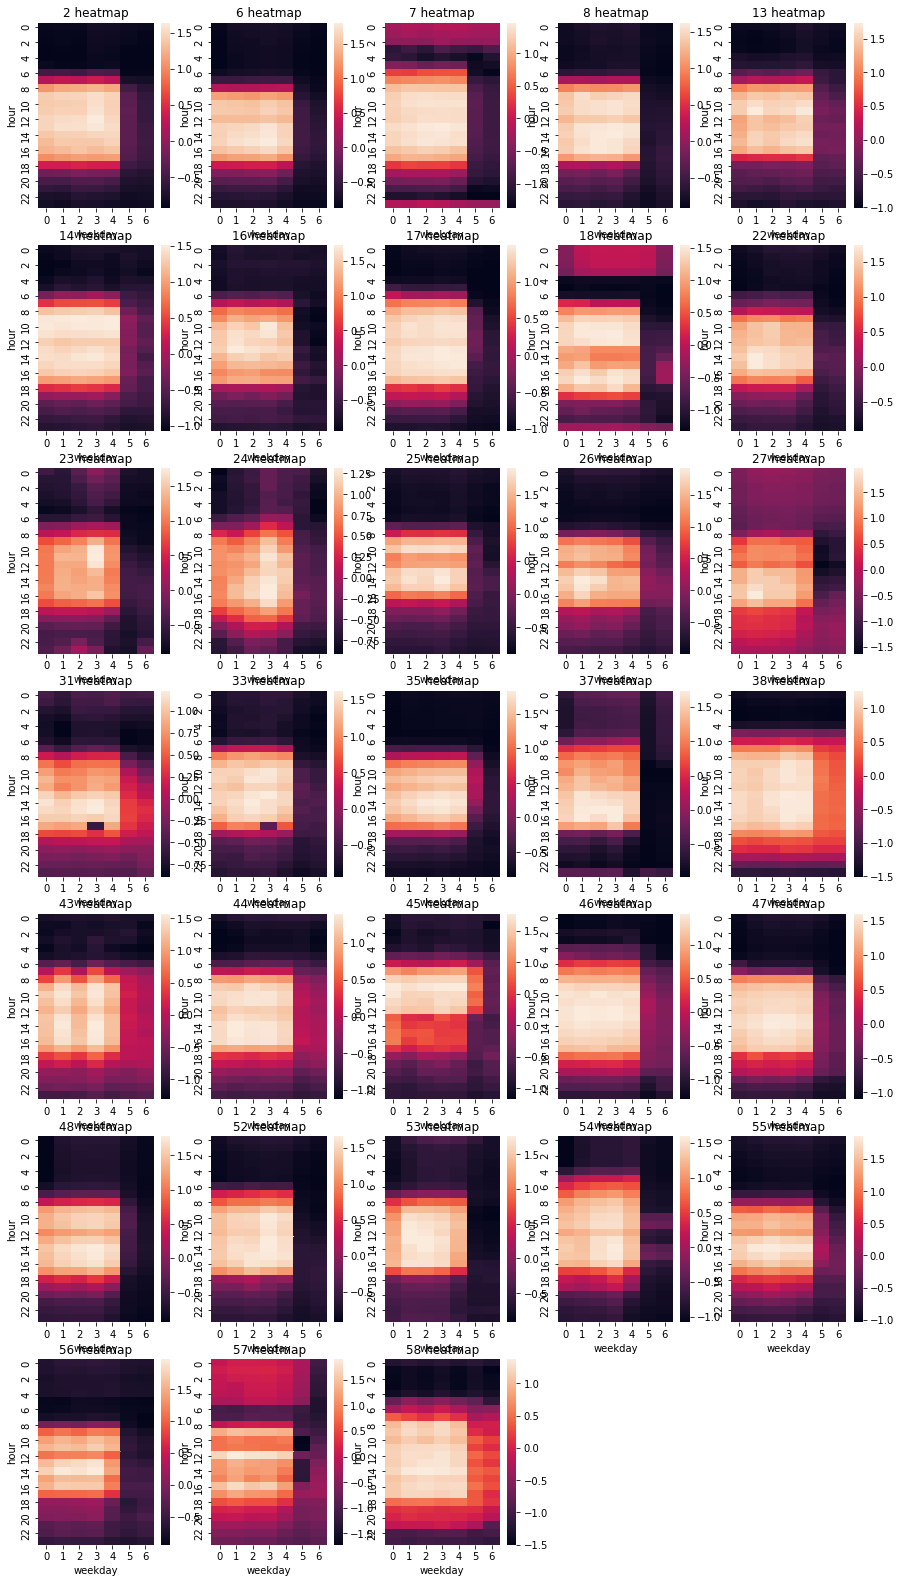

In [33]:
# 1번 cluster
# 대체로 평일 업무 시간대에 전력사용량이 집중되어 있다.
# 그 외의 시간과 요일에는 전력사용량이 급격히 감소. 오피스형 건물이라 추정


fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

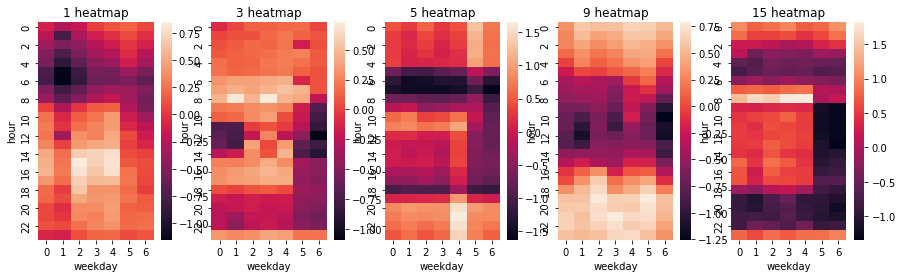

In [34]:
# 2번 cluster
# 딱히 공통된 특징이 없고 불분명한 패턴
# 다른 cluster에 끼지 못한 건물들이 모인듯 모인다. 같은 군집이라 칭하기 난감할 정도


fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

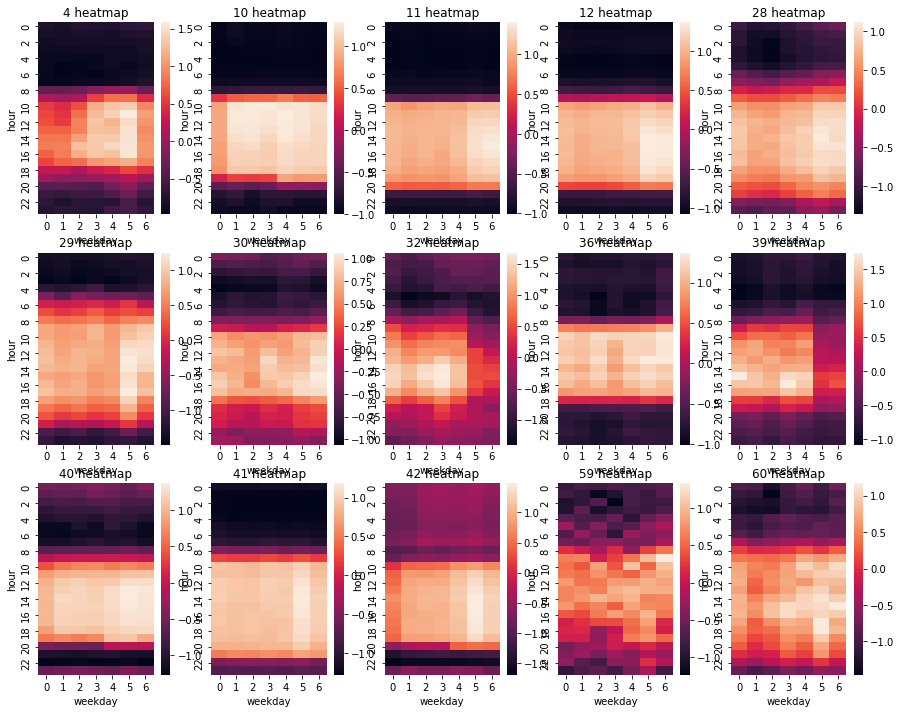

In [35]:
# 3번 cluster
# 평일과 주말을 구분하지 않고 전력사용량이 이어지고 있다.
# 특히나 10~10 시간대에 주로 전력사용량이 집중되어 있는 것으로 보아 상업용 건물이라 추정


fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(np.ceil(len(km_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

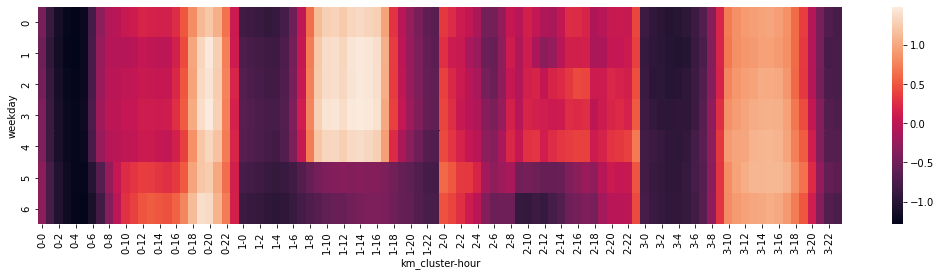

In [36]:
# 각 cluster들 비교
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

# 기상 정보를 기반으로 분석

상관계수 구하기

In [37]:
# 피어슨 상관계수
from scipy.stats import pearsonr

In [38]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

In [39]:
corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()

In [40]:
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [41]:
# 건물별로, 기상요인별로 상관계수를 계산.
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].wind,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [42]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)

기온

In [43]:
corrs_temp_temp = (corrs_cl_temp.temp_corr
                   .reset_index()
                   .sort_values(by=['temp_corr'], ascending=False)
                  .set_index(['num'], drop=False))

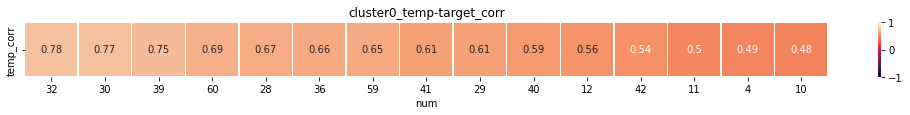

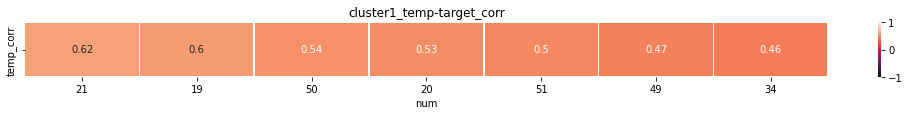

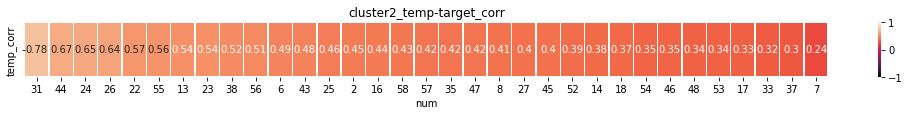

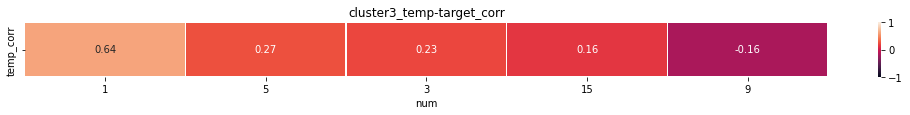

In [44]:
plt.figure(figsize=(18, 1))
plt.title('cluster0_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster1_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster2_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster3_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()



습도

In [45]:
corrs_temp_temp = (corrs_cl_temp.humid_corr
                   .reset_index()
                   .sort_values(by=['humid_corr'], ascending=True)
                  .set_index(['num'], drop=False))

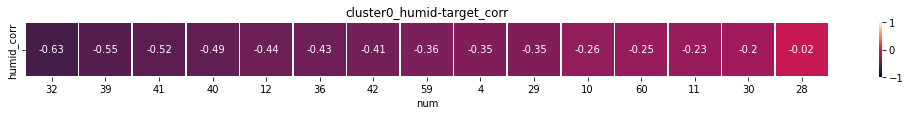

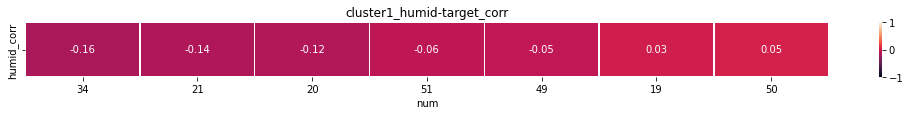

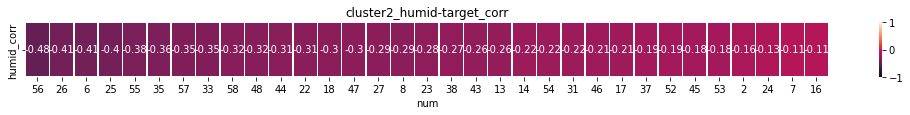

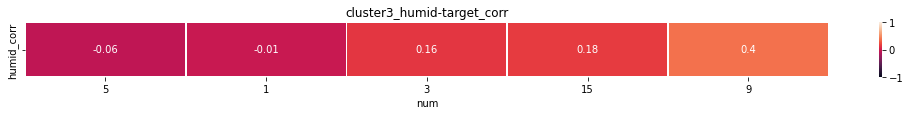

In [46]:
plt.figure(figsize=(18, 1))
plt.title('cluster0_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster1_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster2_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster3_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()



바람

In [47]:
corrs_temp_temp = (corrs_cl_temp.wind_corr
                   .reset_index()
                   .sort_values(by=['wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))

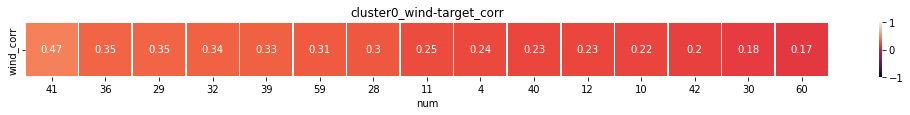

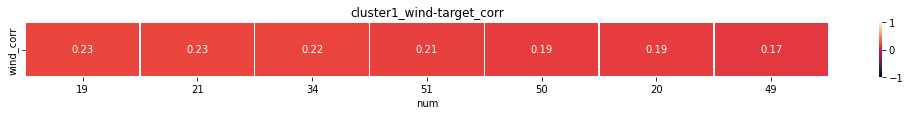

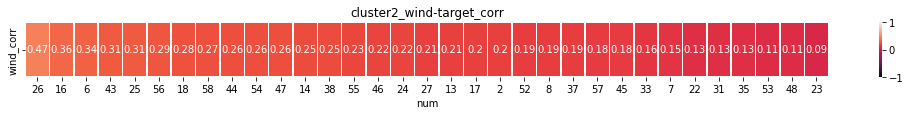

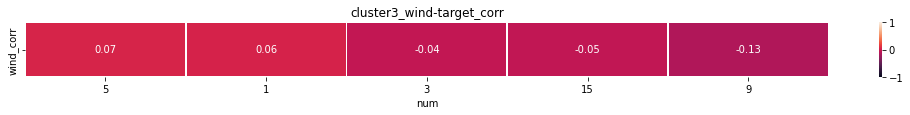

In [48]:
plt.figure(figsize=(18, 1))
plt.title('cluster0_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster1_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster2_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('cluster3_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()



태양광과 비전기 냉방 시설이 전력 사용량에 미치는 영향

In [49]:
cs_temp = train_cl.groupby(['km_cluster', 'num']).max().reset_index().groupby(['km_cluster'])['cooler', 'solar'].sum()

In [50]:
double_temp = train_cl[['km_cluster', 'num', 'solar', 'cooler']].drop_duplicates().set_index('num')
double_temp['double'] = double_temp.solar + double_temp.cooler

In [51]:
cs_temp['double'] = double_temp.loc[double_temp.double == 2].km_cluster.value_counts()

In [52]:
cs_temp['buildings'] = train_cl.groupby(['km_cluster'])['num'].count()/2040

In [53]:
cs_temp['cooler_rate'] = cs_temp.cooler / cs_temp.buildings
cs_temp['solar_rate'] = cs_temp.solar / cs_temp.buildings
cs_temp['double_rate'] = cs_temp.double / cs_temp.buildings

In [54]:
cs_temp

,cooler,solar,double,buildings,cooler_rate,solar_rate,double_rate
km_cluster,,,,,,,
0,1,3,1,7.0,0.142857,0.428571,0.142857
1,26,16,12,33.0,0.787879,0.484848,0.363636
2,3,2,1,5.0,0.600000,0.400000,0.200000
3,11,8,7,15.0,0.733333,0.533333,0.466667


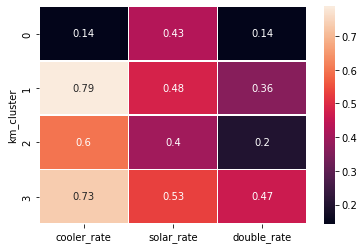

In [55]:
sns.heatmap(cs_temp[['cooler_rate', 'solar_rate', 'double_rate']],
           annot=True, linewidths=.5)
plt.show()

solar는 모든 건물 유형에서 유사한 비율을 가지고 있다.
cooler는 유형별로 매우 편차가 크다.
1번 cluster에는 79%가 설치한 반면, 0번 cluster는 14%만 설치되어있다.
주간에 전력사용량이 집중되어 있는 1번과 3번 cluster의 경우 cooler의 설치 비율이 높고,
밤에 주로 활동을 하는 0번 cluster는 cooler를 설치하지 않은 것으로 보인다.

건물별 상관계수 분석

In [56]:
corrs_system_temp = (corrs_cl_temp[['cooler', 'temp_corr', 'sunny_corr', 'solar']]
                   .reset_index()
                   .sort_values(by=['cooler', 'solar'], ascending=False)
                  .set_index(['num'], drop=False))

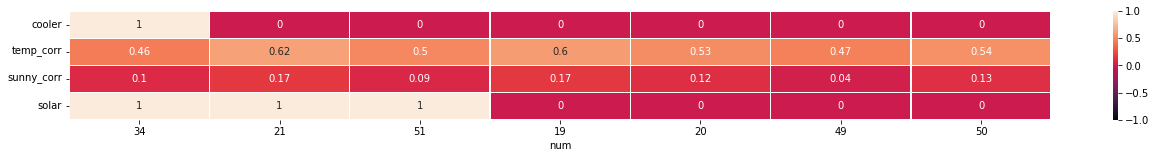

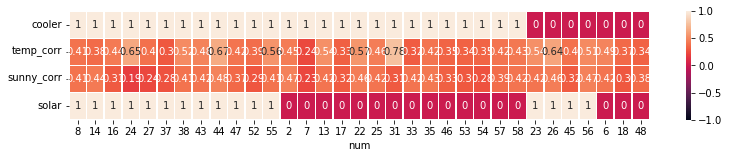

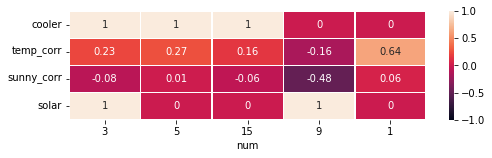

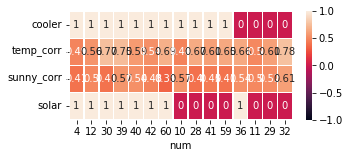

In [57]:
plt.figure(figsize=(22, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 0][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(13, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 1][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(8, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 2][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(5, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 3][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

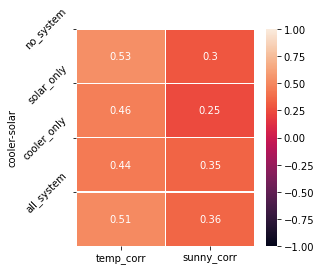

In [58]:
plt.figure(figsize=(4, 4))
sns.heatmap(corrs_cl_temp.groupby(['cooler', 'solar'])[['temp_corr', 'sunny_corr']].mean(),
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.yticks([0, 1, 2, 3], ['no_system', 'solar_only', 'cooler_only', 'all_system'], rotation=45)
plt.show()

뚜렷한 관계성은 잘 모르겠다

비전기 냉방시설 유무에 따른 ...

In [59]:
peak_df_0_1 = train_cl.loc[(train_cl.weekday == 2) & (train_cl.hour == 14) & (train_cl.cooler == 1)]
peak_df_0_0 = train_cl.loc[(train_cl.weekday == 2) & (train_cl.hour == 14) & (train_cl.cooler == 0)]

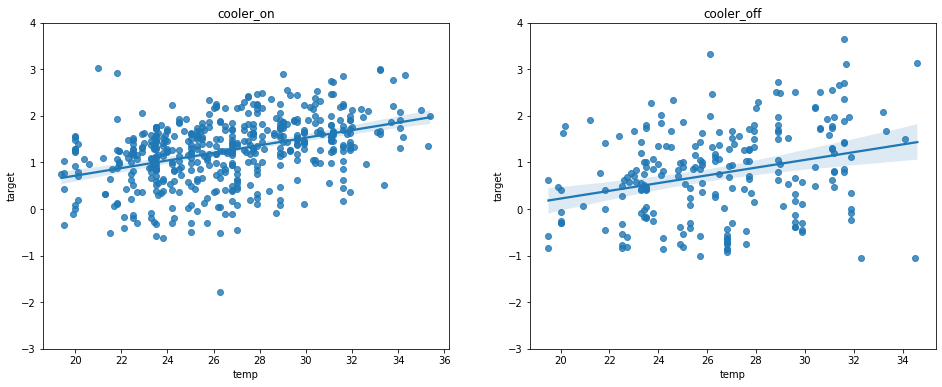

In [60]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("cooler_on")
sns.regplot(data=peak_df_0_1, x='temp', y='target')
plt.ylim(top=4, bottom=-3)

plt.subplot(1, 2, 2)
plt.title("cooler_off")
sns.regplot(data=peak_df_0_0, x='temp', y='target')
plt.ylim(top=4, bottom=-3)

plt.show()

Cooler를 설치한 건물과 설치하지 않은 건물의 뚜렷한 차이는 보이지 않는다.
다만 Cooler를 설치한 건물이 약간 높은 전력사용량을 보이는 정도

태양광시스템

In [61]:
solar_temp = train_cl.groupby(['km_cluster', 'num', 'dayofyear'])[['target', 'sunny', 'solar']].sum().reset_index()

In [62]:
peak_df_1_1 = solar_temp.loc[solar_temp.solar != 0]
peak_df_1_0 = solar_temp.loc[solar_temp.solar == 0]

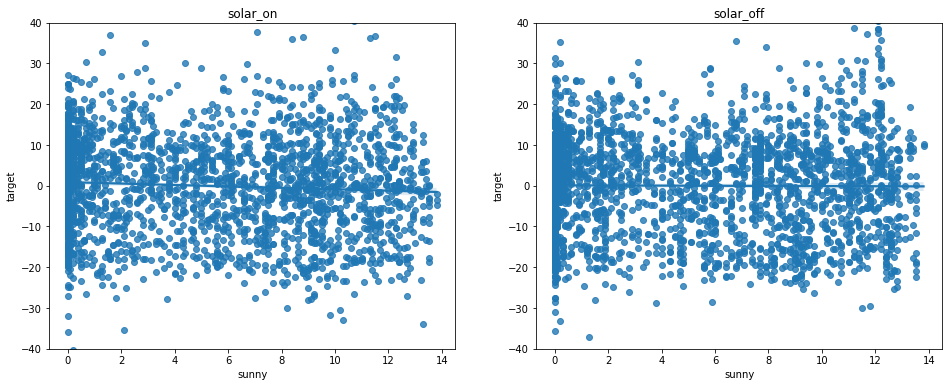

In [63]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("solar_on")
sns.regplot(data=peak_df_1_1, x='sunny', y='target')
plt.ylim(top=40, bottom=-40)

plt.subplot(1, 2, 2)
plt.title("solar_off")
sns.regplot(data=peak_df_1_0, x='sunny', y='target')
plt.ylim(top=40, bottom=-40)

plt.show()

역시 일조시간과 전력사용량 간의 유의미한 관계는 보이지 않는 듯 하다

CDH(cooling degree hour, 냉방도일) 변수.
냉방 기준온도(26도)보다 높은 시점에서 해당 시점의 온도와 기준온도의 차 추가

In [64]:
# CDH feature추가
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,61,1):
    temp = train_origin[train_origin['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
train_origin['CDH'] = cdhs

# mean_CDH
train_origin = train_origin.merge(train_origin.groupby(['num','day'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','day'], how = 'left')

In [65]:
train_origin

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,6,1,0,0,153,0,-8.4,-43.112500
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,6,1,1,0,153,0,-16.7,-43.112500
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,6,1,2,0,153,0,-25.2,-43.112500
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,6,1,3,0,153,0,-34.1,-43.112500
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,6,1,4,0,153,0,-43.1,-43.112500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1,1,8,24,19,0,237,0,30.8,-29.147222
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1,1,8,24,20,0,237,0,32.3,-29.147222
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1,1,8,24,21,0,237,0,32.5,-29.147222
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1,1,8,24,22,0,237,0,31.3,-29.147222


In [66]:
train_origin.loc[train_cl.km_cluster == 1]

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH
2040,2,2020-06-01 00:00:00,977.184,18.3,2.5,94.0,0.0,0.0,1,0,6,1,0,0,153,0,-7.7,-28.886111
2041,2,2020-06-01 01:00:00,966.168,18.8,2.3,89.0,0.0,0.0,1,0,6,1,1,0,153,0,-14.9,-28.886111
2042,2,2020-06-01 02:00:00,972.972,19.0,3.2,86.0,0.0,0.0,1,0,6,1,2,0,153,0,-21.9,-28.886111
2043,2,2020-06-01 03:00:00,965.844,19.0,4.1,85.0,0.0,0.0,1,0,6,1,3,0,153,0,-28.9,-28.886111
2044,2,2020-06-01 04:00:00,971.676,18.9,3.9,87.0,0.0,0.0,1,0,6,1,4,0,153,0,-36.0,-28.886111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118315,58,2020-08-24 19:00:00,959.688,29.4,3.4,66.0,0.0,0.2,1,0,8,24,19,0,237,0,43.7,-21.280556
118316,58,2020-08-24 20:00:00,942.840,28.7,1.9,69.0,0.0,0.0,1,0,8,24,20,0,237,0,47.3,-21.280556
118317,58,2020-08-24 21:00:00,915.300,28.3,1.1,71.0,0.0,0.0,1,0,8,24,21,0,237,0,48.7,-21.280556
118318,58,2020-08-24 22:00:00,691.578,28.3,2.4,72.0,0.0,0.0,1,0,8,24,22,0,237,0,48.4,-21.280556


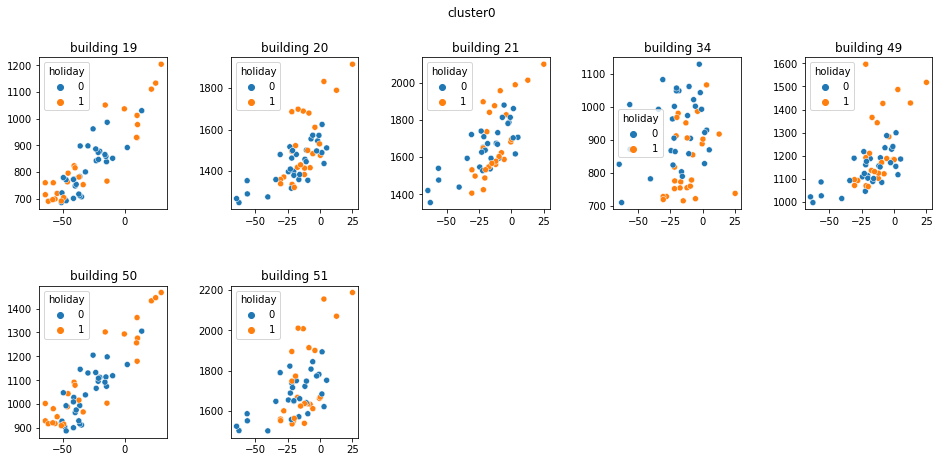

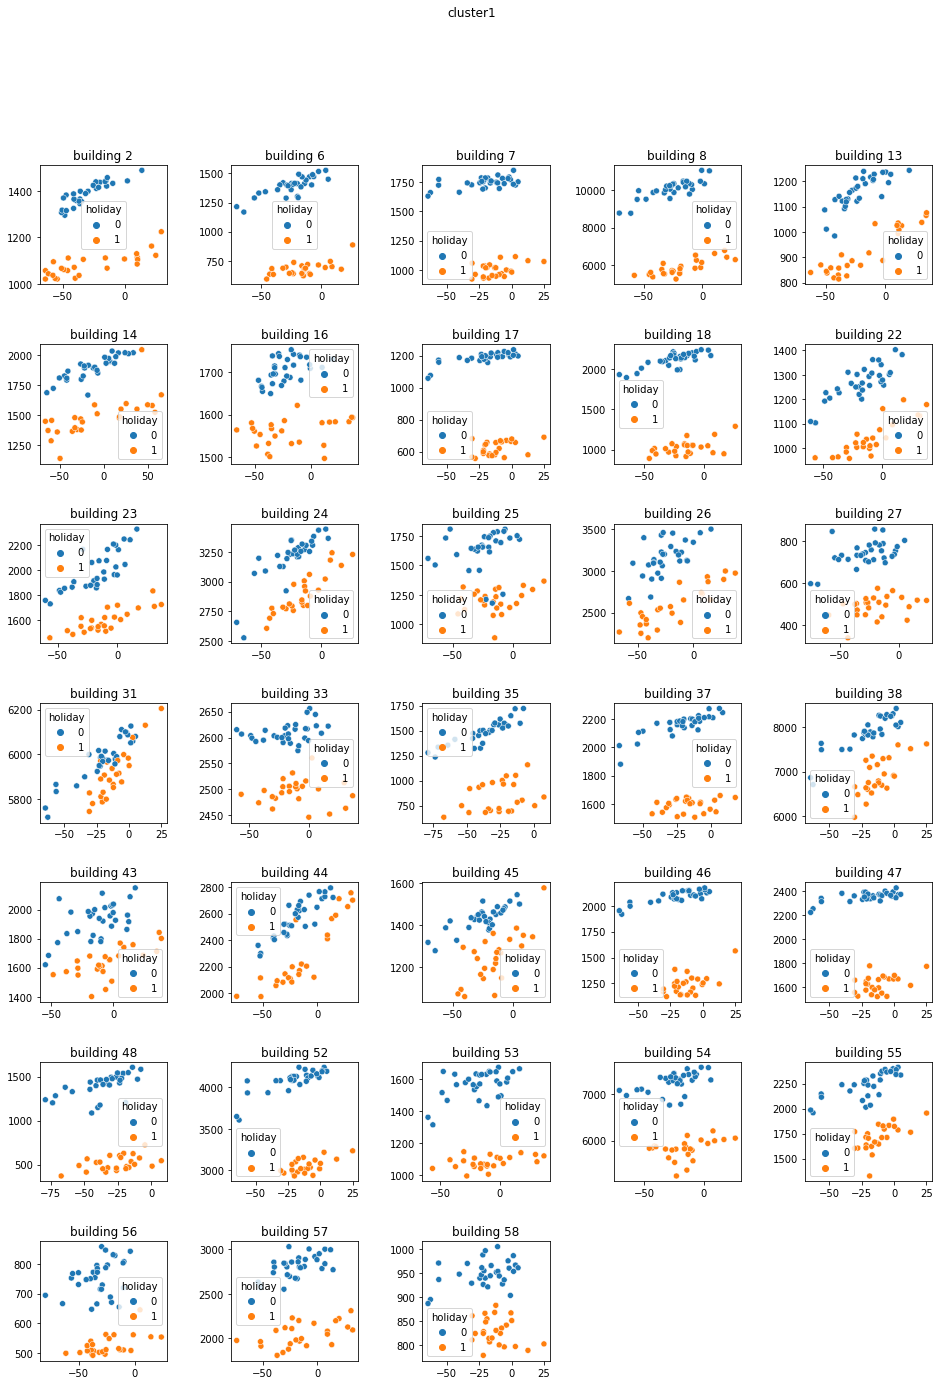

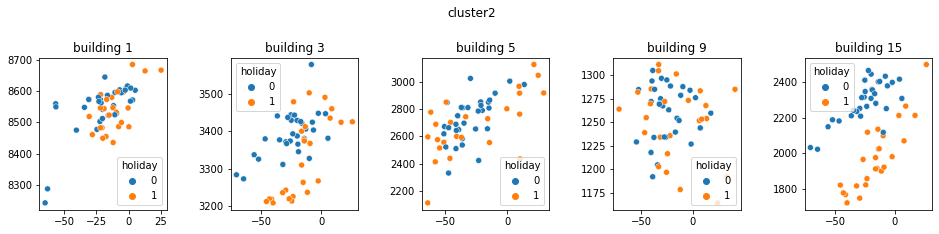

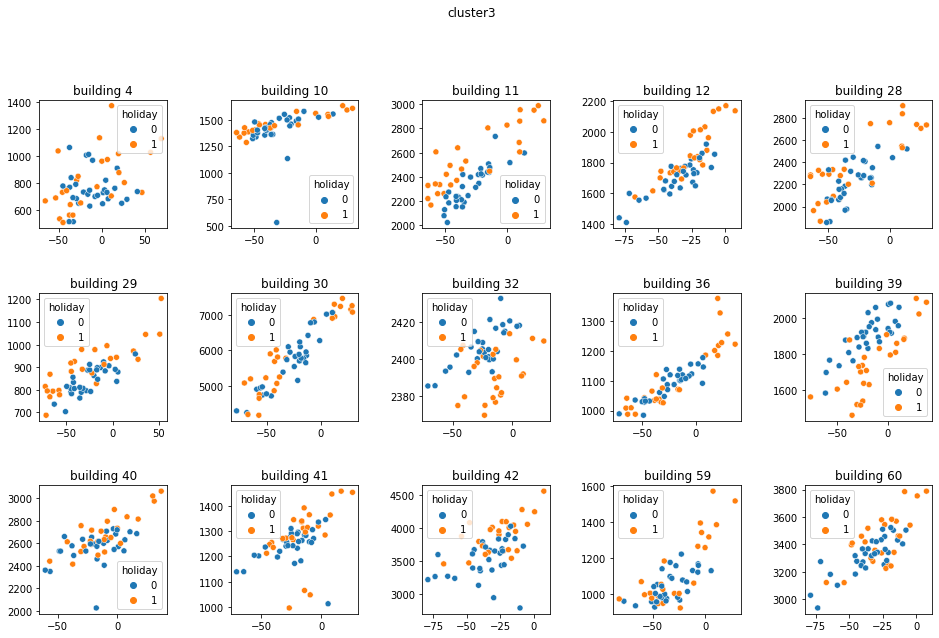

In [67]:
for c in range(4):
    temp_1 = train_origin.loc[train_cl.km_cluster == c] # 
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5+1)+1))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2_tg = temp_2.groupby(['num','day','holiday'])[['target']].mean().reset_index()
        temp_2_cdh = temp_2.groupby(['num','day','holiday'])[['CDH']].mean().reset_index()
        temp_2 = temp_2_tg.merge(temp_2_cdh, on = ['num','day','holiday'], how= 'left')
        plt.subplot(n_nums//5+1,5, i+1)
        sns.scatterplot(data = temp_2, x='CDH', y='target', hue= 'holiday')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

불쾌지수(THI) 추가

불쾌지수를 계산하여, 쾌적/다소 불쾌/불쾌/ 매우 불쾌 4개의 카테고리로 나눔

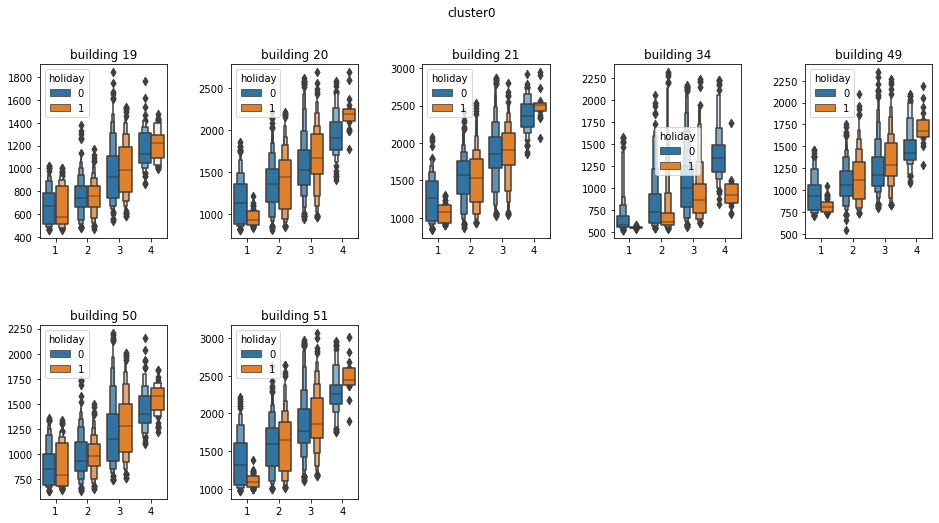

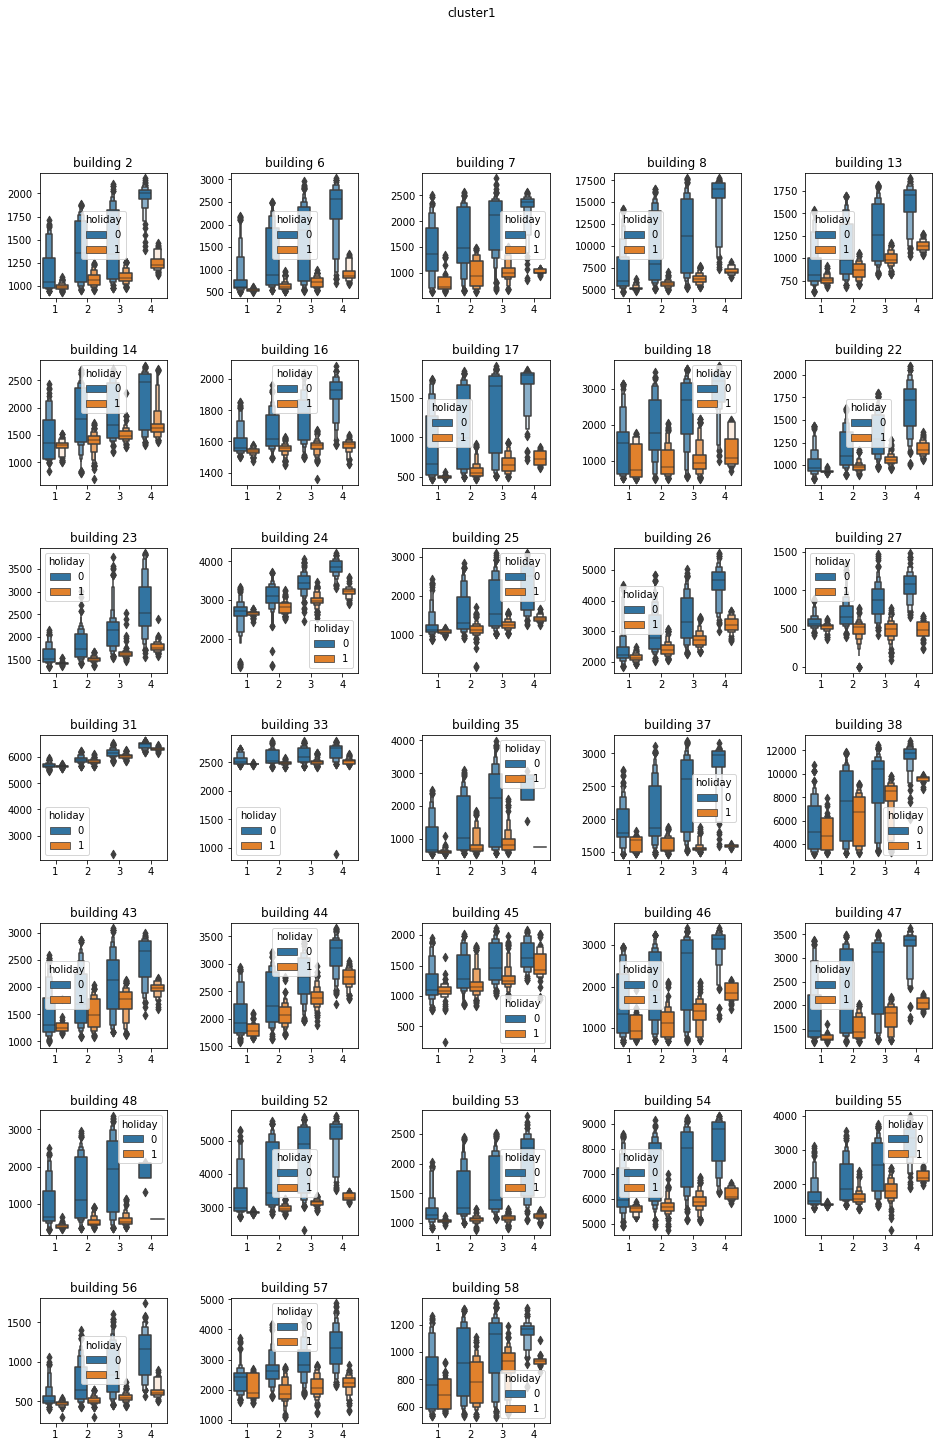

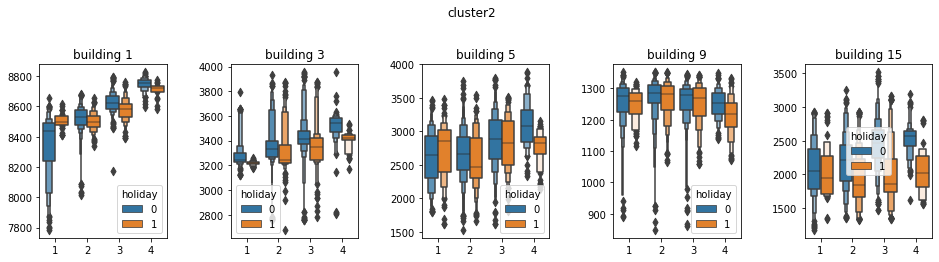

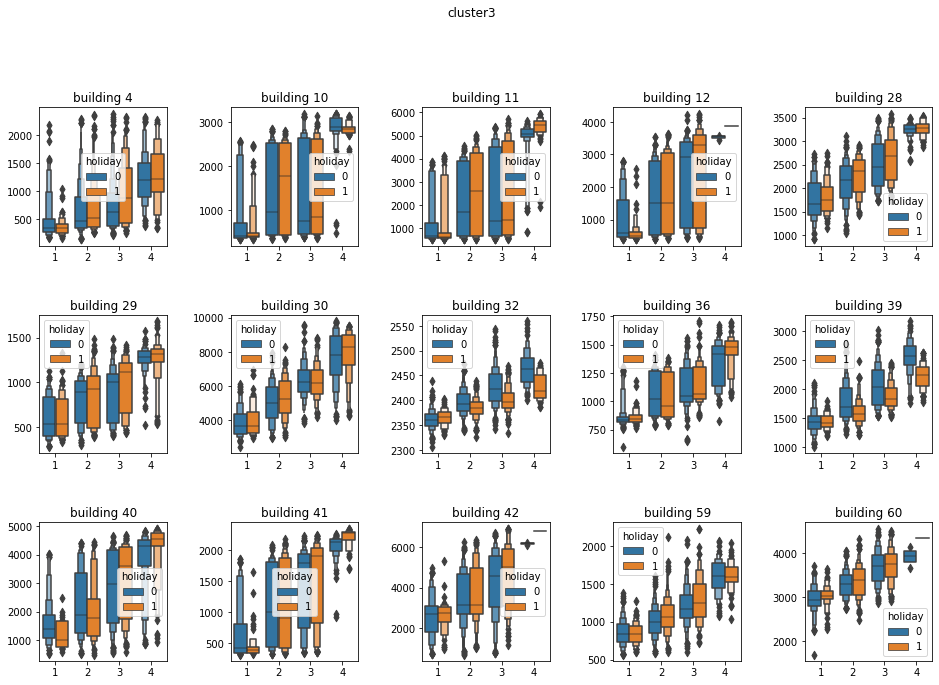

In [68]:
train_origin['THI'] = 9/5*train_origin['temp'] - 0.55*(1-train_origin['humid']/100)*(9/5*train_origin['temp']-26)+32
train_origin['THI_cat'] = pd.cut(train_origin['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])

for c in range(4):
    temp_1 = train_origin.loc[train_cl.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)+2))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums//5+1,5, i+1)
        sns.boxenplot(data = temp_2, x='THI_cat', y='target', hue= 'holiday')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

*   전반적으로, temperature, THI(불쾌지수), CDH(냉방도일)의 평균값이 일일 에너지 사용량 평균치와 높은 상관관계


In [69]:
train_origin

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,6,1,0,0,153,0,-8.4,-43.112500,63.43008,1
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,6,1,1,0,153,0,-16.7,-43.112500,63.56993,1
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,6,1,2,0,153,0,-25.2,-43.112500,63.22775,1
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,6,1,3,0,153,0,-34.1,-43.112500,62.54339,1
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,6,1,4,0,153,0,-43.1,-43.112500,62.39760,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1,1,8,24,19,0,237,0,30.8,-29.147222,77.80896,3
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1,1,8,24,20,0,237,0,32.3,-29.147222,77.44917,3
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1,1,8,24,21,0,237,0,32.5,-29.147222,77.44917,3
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1,1,8,24,22,0,237,0,31.3,-29.147222,77.52246,3


In [70]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

,num
km_cluster,
0,7.0
1,33.0
2,5.0
3,15.0


test에 CDH, THI 변수 추가

In [71]:
# CDH
cdhs = np.array([])
for num in range(1,61,1):
    temp = test[test['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

# mean_CDH
test = test.merge(test.groupby(['num','day'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','day'], how = 'left')

In [72]:
# THI와 불쾌한 정도인 THI_cat
test['THI'] = 9/5*test['temp'] - 0.55*(1-test['humid']/100)*(9/5*test['temp']-26)+32
test['THI_cat'] = pd.cut(test['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])

In [73]:
test

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0,1.8,32.816667,78.602280,3
1,1,2020-08-25 01:00:00,27.6,1.4,75.3,0.0,0.0,0.0,0.0,8,25,1,1,238,0,3.4,32.816667,78.463072,3
2,1,2020-08-25 02:00:00,27.5,1.2,76.7,0.0,0.0,0.0,0.0,8,25,2,1,238,0,4.9,32.816667,78.488475,3
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,0,6.2,32.816667,78.340060,3
4,1,2020-08-25 04:00:00,26.9,1.2,79.7,0.0,0.0,0.0,0.0,8,25,4,1,238,0,7.1,32.816667,77.916807,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.6,3.6,66.0,0.0,0.5,1.0,1.0,8,31,19,0,244,0,22.4,6.741667,78.715240,3
10076,60,2020-08-31 20:00:00,28.3,3.8,67.0,0.0,0.3,1.0,1.0,8,31,20,0,244,0,25.4,6.741667,78.413390,3
10077,60,2020-08-31 21:00:00,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,21,0,244,0,27.7,6.741667,77.957280,3
10078,60,2020-08-31 22:00:00,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,22,0,244,0,29.3,6.741667,77.957280,3


In [74]:
# feature 수정한 test 저장
test_origin = test.copy()

# 3. modeling- Random Forest

군집 별 모델링을 수행하고자 한다.

해당 군집에 속하더라도, 같은 모델로 설명이 부족한 건물이 있을 수 있으므로 먼저 Random Forest OOB Score를 통한 모델 설명력을 확인한다

In [75]:
train = train_origin.copy()
# test = test.copy()
sub = pd.read_csv('sample_submission.csv', encoding='cp949')

In [76]:
# date_time 제거
train.drop(['date_time'], axis=1, inplace=True)
test.drop(['date_time'], axis=1, inplace=True)

In [77]:
train

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,6,1,0,0,153,0,-8.4,-43.112500,63.43008,1
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,6,1,1,0,153,0,-16.7,-43.112500,63.56993,1
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,6,1,2,0,153,0,-25.2,-43.112500,63.22775,1
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,6,1,3,0,153,0,-34.1,-43.112500,62.54339,1
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,6,1,4,0,153,0,-43.1,-43.112500,62.39760,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1,1,8,24,19,0,237,0,30.8,-29.147222,77.80896,3
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1,1,8,24,20,0,237,0,32.3,-29.147222,77.44917,3
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1,1,8,24,21,0,237,0,32.5,-29.147222,77.44917,3
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1,1,8,24,22,0,237,0,31.3,-29.147222,77.52246,3


In [78]:
test

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat
0,1,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0,1.8,32.816667,78.602280,3
1,1,27.6,1.4,75.3,0.0,0.0,0.0,0.0,8,25,1,1,238,0,3.4,32.816667,78.463072,3
2,1,27.5,1.2,76.7,0.0,0.0,0.0,0.0,8,25,2,1,238,0,4.9,32.816667,78.488475,3
3,1,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,0,6.2,32.816667,78.340060,3
4,1,26.9,1.2,79.7,0.0,0.0,0.0,0.0,8,25,4,1,238,0,7.1,32.816667,77.916807,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.6,3.6,66.0,0.0,0.5,1.0,1.0,8,31,19,0,244,0,22.4,6.741667,78.715240,3
10076,60,28.3,3.8,67.0,0.0,0.3,1.0,1.0,8,31,20,0,244,0,25.4,6.741667,78.413390,3
10077,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,21,0,244,0,27.7,6.741667,77.957280,3
10078,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,22,0,244,0,29.3,6.741667,77.957280,3


In [79]:
preds = []
oob_scores = []
for i in tqdm(range(1, 61)):
    # 건물별로 데이터 할당
    x_train_building = train.loc[train.num == i, ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    y_train_building = train.loc[train.num == i, 'target']
    x_test_building = test.loc[test.num == i, ~test.columns.isin(['num', 'cooler', 'solar'])]
    
    # 학습 및 예측
    rf = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
    rf.fit(x_train_building, y_train_building)
    pred = rf.predict(x_test_building)
    preds.append(pred.tolist())
    oob_scores.append(rf.oob_score_)

100%|██████████| 60/60 [00:54<00:00,  1.10it/s]


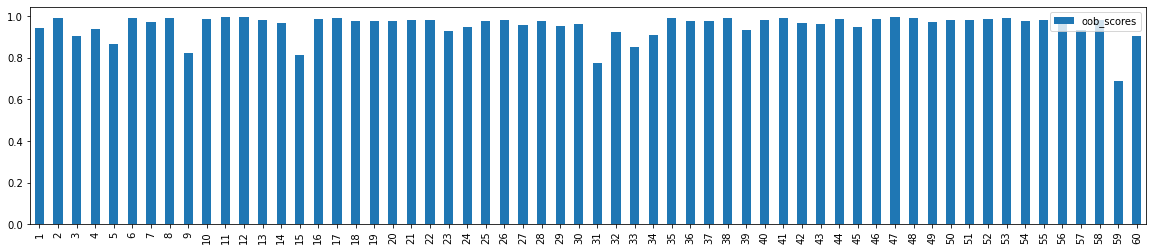

In [80]:
# 건물별 oob_score 플롯팅
pd.DataFrame(data=oob_scores, index=list(range(1, 61)), columns=['oob_scores']).plot(kind='bar', figsize=(20, 4))
plt.show()

In [81]:
oob_df = pd.DataFrame(data=oob_scores, index=list(range(1, 61)), columns=['oob_scores']).reset_index()
oob_df.sort_values(by=['oob_scores']).reset_index(drop=True)[:12]


,index,oob_scores
0,59,0.689975
1,31,0.777764
2,15,0.815943
3,9,0.821921
4,33,0.852349
5,5,0.868935
6,3,0.906810
7,60,0.907245
8,34,0.907797
9,32,0.924147


oob_score가 0.93보다 낮은 11개의 건물들은 개별적으로 모델링 진행하려 함

2번 cluster에서는 1번 건물만 남게 되었다

In [82]:
# dataset 합치기

X = pd.concat([train, train_cl['km_cluster']], axis=1)
y = pd.concat([test, test_cl['km_cluster']], axis=1)

In [83]:
X

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat,km_cluster
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,6,1,0,0,153,0,-8.4,-43.112500,63.43008,1,2
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,6,1,1,0,153,0,-16.7,-43.112500,63.56993,1,2
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,6,1,2,0,153,0,-25.2,-43.112500,63.22775,1,2
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,6,1,3,0,153,0,-34.1,-43.112500,62.54339,1,2
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,6,1,4,0,153,0,-43.1,-43.112500,62.39760,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1,1,8,24,19,0,237,0,30.8,-29.147222,77.80896,3,3
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1,1,8,24,20,0,237,0,32.3,-29.147222,77.44917,3,3
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1,1,8,24,21,0,237,0,32.5,-29.147222,77.44917,3,3
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1,1,8,24,22,0,237,0,31.3,-29.147222,77.52246,3,3


In [84]:
y

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat,km_cluster
0,1,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0,1.8,32.816667,78.602280,3,2.0
1,1,27.6,1.4,75.3,0.0,0.0,0.0,0.0,8,25,1,1,238,0,3.4,32.816667,78.463072,3,2.0
2,1,27.5,1.2,76.7,0.0,0.0,0.0,0.0,8,25,2,1,238,0,4.9,32.816667,78.488475,3,2.0
3,1,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,0,6.2,32.816667,78.340060,3,2.0
4,1,26.9,1.2,79.7,0.0,0.0,0.0,0.0,8,25,4,1,238,0,7.1,32.816667,77.916807,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.6,3.6,66.0,0.0,0.5,1.0,1.0,8,31,19,0,244,0,22.4,6.741667,78.715240,3,3.0
10076,60,28.3,3.8,67.0,0.0,0.3,1.0,1.0,8,31,20,0,244,0,25.4,6.741667,78.413390,3,3.0
10077,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,21,0,244,0,27.7,6.741667,77.957280,3,3.0
10078,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,22,0,244,0,29.3,6.741667,77.957280,3,3.0


In [85]:
others = [59, 31, 33, 34, 60, 23, 32, 39, 3, 5, 9, 15]
for other, km_num in zip(others, range(4, len(others) + 4)):
    X.loc[X.num == other, 'km_cluster'] = km_num
    y.loc[y.num == other, 'km_cluster'] = km_num

In [86]:
train_cl_0 = X.loc[X.km_cluster == 0,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_1 = X.loc[X.km_cluster == 1,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_2 = X.loc[X.km_cluster == 2,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_3 = X.loc[X.km_cluster == 3,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)

# 별도 모델링
# 건물별로 모델링을 할 때는 단일 값인 cooler, solar, num을 제거합니다.
for i in range(4, len(others) + 4):
    globals()['train_cl_{}'.format(i)] = X.loc[X.km_cluster == i,
                                               ~X.columns.isin(['target', 'km_cluster', 'date_time', 'cooler', 'solar', 'num'])].reset_index(drop=True)

In [87]:
X.loc[X.km_cluster == 2]

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat,km_cluster
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,6,1,0,0,153,0,-8.4,-43.112500,63.43008,1,2
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,6,1,1,0,153,0,-16.7,-43.112500,63.56993,1,2
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,6,1,2,0,153,0,-25.2,-43.112500,63.22775,1,2
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,6,1,3,0,153,0,-34.1,-43.112500,62.54339,1,2
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,6,1,4,0,153,0,-43.1,-43.112500,62.39760,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,1,8714.952,29.4,3.4,66.0,0.0,0.2,0,0,8,24,19,0,237,0,43.7,-21.280556,79.88596,3,2
2036,1,8740.224,28.7,1.9,69.0,0.0,0.0,0,0,8,24,20,0,237,0,47.3,-21.280556,79.28497,3,2
2037,1,8730.504,28.3,1.1,71.0,0.0,0.0,0,0,8,24,21,0,237,0,48.7,-21.280556,78.96207,3,2
2038,1,8725.968,28.3,2.4,72.0,0.0,0.0,0,0,8,24,22,0,237,0,48.4,-21.280556,79.09924,3,2


In [88]:
train_cl_0_y = X.loc[X.km_cluster == 0, 'target'].reset_index(drop=True)
train_cl_1_y = X.loc[X.km_cluster == 1, 'target'].reset_index(drop=True)
train_cl_2_y = X.loc[X.km_cluster == 2, 'target'].reset_index(drop=True)
train_cl_3_y = X.loc[X.km_cluster == 3, 'target'].reset_index(drop=True)

# 별도 모델링
for i in range(4, len(others) + 4):
    globals()['train_cl_{}_y'.format(i)] = X.loc[X.km_cluster == i, 'target'].reset_index(drop=True)

In [89]:
test_cl_0 = y.loc[y.km_cluster == 0, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_1 = y.loc[y.km_cluster == 1, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_2 = y.loc[y.km_cluster == 2, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_3 = y.loc[y.km_cluster == 3, ~y.columns.isin(['km_cluster', 'date_time'])]

# 별도 모델링
# 건물별로 모델링을 할 때는 단일 값인 cooler, solar, num을 제거합니다.
for i in range(4, len(others) + 4):
    globals()['test_cl_{}'.format(i)] = y.loc[y.km_cluster == i, ~y.columns.isin(['km_cluster', 'date_time', 'cooler', 'solar', 'num'])]

In [90]:
train_x_sets = [train_cl_0, train_cl_1, train_cl_2, train_cl_3,
               train_cl_4, train_cl_5, train_cl_6, train_cl_7,
               train_cl_8, train_cl_9, train_cl_10, train_cl_11,
               train_cl_12, train_cl_13, train_cl_14, train_cl_15]
train_y_sets = [train_cl_0_y, train_cl_1_y, train_cl_2_y, train_cl_3_y,
               train_cl_4_y, train_cl_5_y, train_cl_6_y, train_cl_7_y,
               train_cl_8_y, train_cl_9_y, train_cl_10_y, train_cl_11_y,
               train_cl_12_y, train_cl_13_y, train_cl_14_y, train_cl_15_y]
test_x_sets = [test_cl_0, test_cl_1, test_cl_2, test_cl_3,
              test_cl_4, test_cl_5, test_cl_6, test_cl_7,
              test_cl_8, test_cl_9, test_cl_10, test_cl_11,
              test_cl_12, test_cl_13, test_cl_14, test_cl_15]
"""train_x_sets = [train_cl_0, train_cl_2, train_cl_3]
train_y_sets = [train_cl_0_y, train_cl_2_y, train_cl_3_y]
test_x_sets = [test_cl_0, test_cl_2, test_cl_3]"""

'train_x_sets = [train_cl_0, train_cl_2, train_cl_3]\ntrain_y_sets = [train_cl_0_y, train_cl_2_y, train_cl_3_y]\ntest_x_sets = [test_cl_0, test_cl_2, test_cl_3]'

In [91]:
train_cl_0

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat
0,19,18.3,2.5,94.0,0.0,0.0,0,0,6,1,0,0,153,0,-7.7,-28.886111,64.71098,1
1,19,18.8,2.3,89.0,0.0,0.0,0,0,6,1,1,0,153,0,-14.9,-28.886111,65.36568,1
2,19,19.0,3.2,86.0,0.0,0.0,0,0,6,1,2,0,153,0,-21.9,-28.886111,65.56860,1
3,19,19.0,4.1,85.0,0.0,0.0,0,0,6,1,3,0,153,0,-28.9,-28.886111,65.52350,1
4,19,18.9,3.9,87.0,0.0,0.0,0,0,6,1,4,0,153,0,-36.0,-28.886111,65.44657,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,51,29.4,3.4,66.0,0.0,0.2,0,1,8,24,19,0,237,0,43.7,-21.280556,79.88596,3
12236,51,28.7,1.9,69.0,0.0,0.0,0,1,8,24,20,0,237,0,47.3,-21.280556,79.28497,3
12237,51,28.3,1.1,71.0,0.0,0.0,0,1,8,24,21,0,237,0,48.7,-21.280556,78.96207,3
12238,51,28.3,2.4,72.0,0.0,0.0,0,1,8,24,22,0,237,0,48.4,-21.280556,79.09924,3


In [92]:
test_cl_0

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat
3024,19,26.7,0.9,87.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0,0.7,27.391667,78.482710,3
3025,19,26.5,0.9,87.0,0.0,0.0,0.0,0.0,8,25,1,1,238,0,1.2,27.391667,78.148450,3
3026,19,26.4,0.9,87.0,0.0,0.0,0.0,0.0,8,25,2,1,238,0,1.6,27.391667,77.981320,3
3027,19,26.2,0.9,87.0,0.0,0.0,0.0,0.0,8,25,3,1,238,0,1.8,27.391667,77.647060,3
3028,19,26.1,0.8,86.7,0.0,0.0,0.0,0.0,8,25,4,1,238,0,1.9,27.391667,77.445313,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,51,28.2,2.8,72.7,0.0,0.8,0.0,1.0,8,31,19,0,244,0,18.1,2.800000,79.042286,3
8564,51,27.7,2.6,73.3,0.0,0.4,0.0,1.0,8,31,20,0,244,0,20.9,2.800000,78.356159,3
8565,51,27.1,2.4,74.0,0.0,0.0,0.0,1.0,8,31,21,0,244,0,22.6,2.800000,77.522460,3
8566,51,27.3,2.1,74.0,0.0,0.0,0.0,1.0,8,31,22,0,244,0,24.0,2.800000,77.830980,3


In [93]:
# feature 추가한 train/test set 저장
my_train_x_sets = train_x_sets.copy()
my_train_y_sets = train_y_sets.copy()
my_test_x_sets = test_x_sets.copy()


In [94]:
preds = []
fe = []

for x, y, t in zip(train_x_sets, train_y_sets, test_x_sets):
    rf = RandomForestRegressor(random_state=42,
                               n_estimators=200,
                               n_jobs = -1)
    rf.fit(x, y)
    pred = rf.predict(t)
    preds.append(pred)
    fe.append(rf.feature_importances_)


In [95]:
pred_set = []
for te, p in zip(test_x_sets, preds):
    te['pred'] = p
    pred_set.append(te)

In [96]:
pred_set = pd.concat(pred_set).sort_index()

In [97]:
sub.answer = pred_set.pred

In [98]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8665.53876
1,1 2020-08-25 01,8664.79680
2,1 2020-08-25 02,8662.27932
3,1 2020-08-25 03,8647.96824
4,1 2020-08-25 04,8613.43956
...,...,...
10075,60 2020-08-31 19,4154.26536
10076,60 2020-08-31 20,4052.28744
10077,60 2020-08-31 21,3802.18320
10078,60 2020-08-31 22,3590.77536


In [99]:
# 현재까지 3번 저장함
sub.to_csv("/content/drive/MyDrive/dataSience/energy/data/testScore2.csv", index=False)


# 군집별 feature 중요도 분석

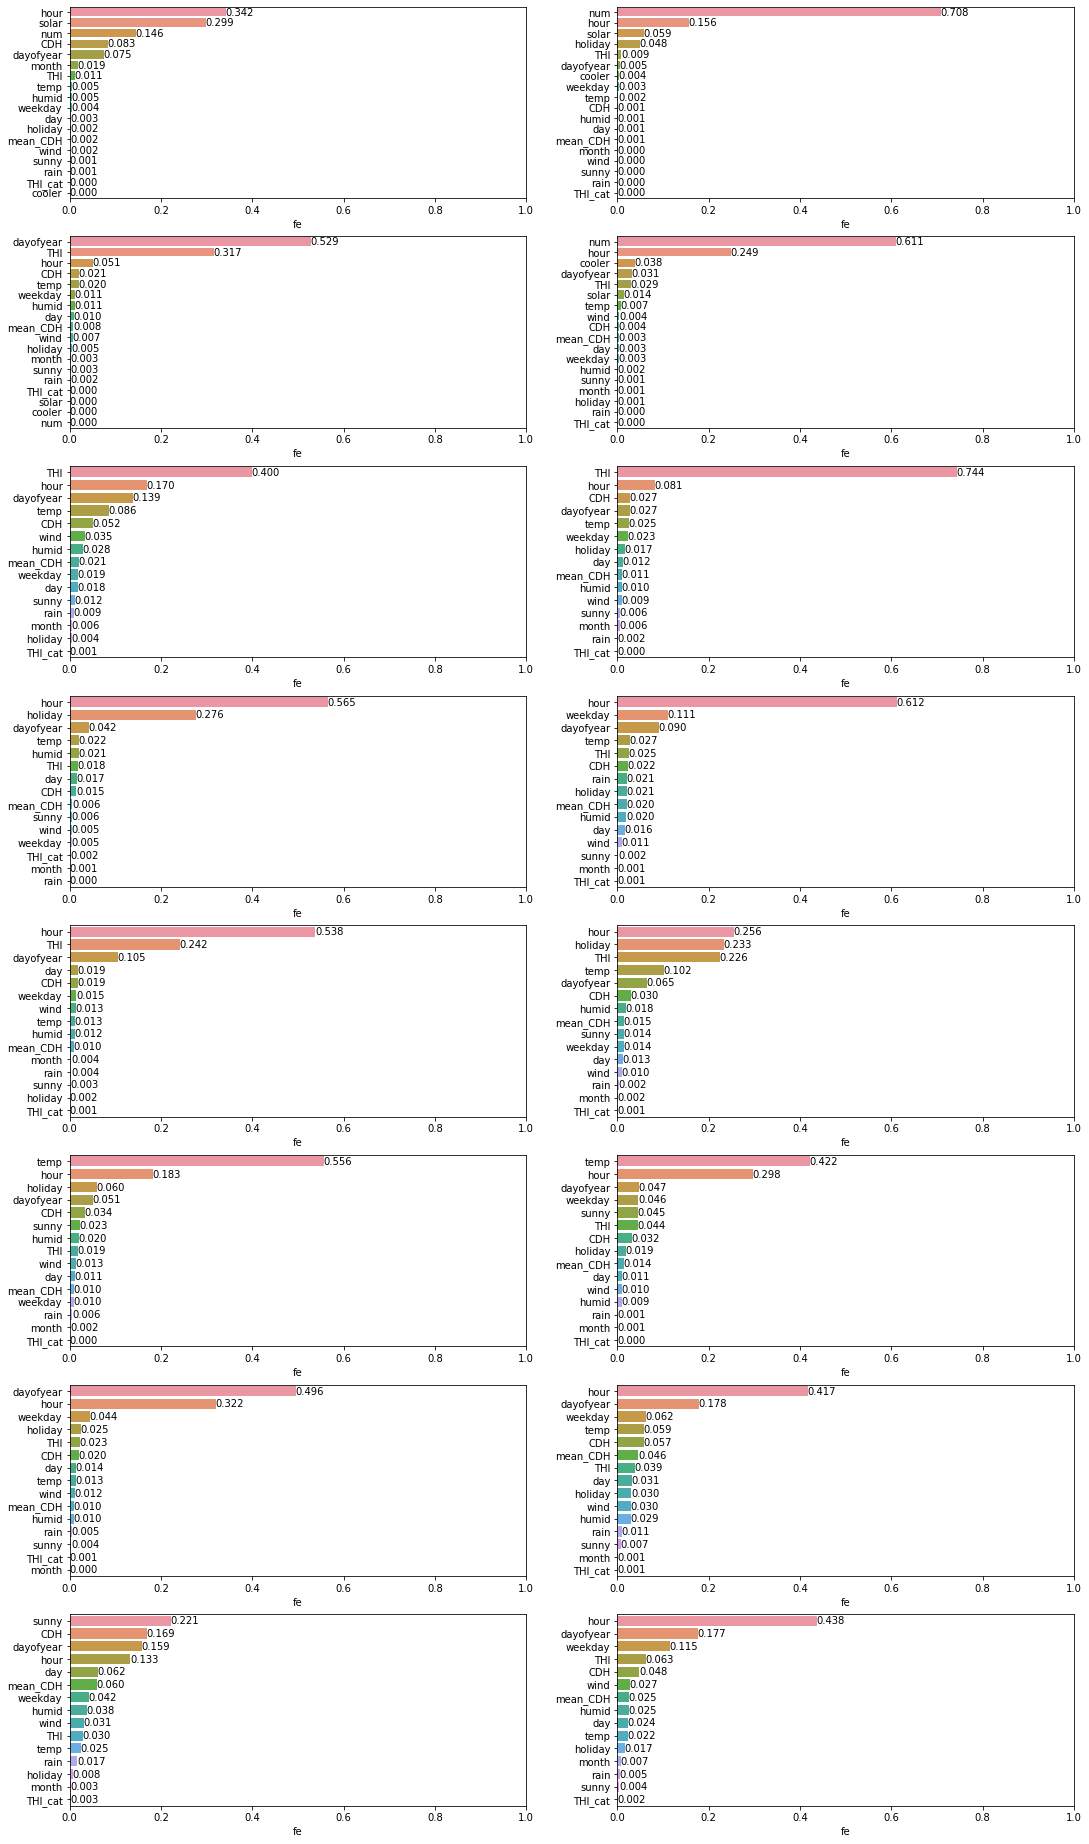

In [100]:
fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(range(len(X.km_cluster.unique()))):
    plt.subplot(12, 2, i+1)
    if len(fe[i]) == 18:
        fe_avg = pd.DataFrame(fe[i], index=train_cl_0.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
    else:
        fe_avg = pd.DataFrame(fe[i], index=train_cl_5.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
        
    plt.xlim(right=1)
    plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

    # Annotate every single Bar with its value, based on it's width            
    for bar in plots.patches:
        width = bar.get_width()
        plt.text(0.03 + bar.get_width(),
                 bar.get_y() + 0.5 * bar.get_height(),
                 '{:.3f}'.format(width),
                 ha='center', va='center')

군집별로 중요한 feature가 temp, hour, dayofyear 등등 모두 다르다

새로 추가한 CDH, THI 등이 모델에 유의미한 영향을 끼쳤음을 확인

반면, 불쾌한 정도였던 THI_cat 처럼 거의 영향을 미치지 못한 경우도 있었던 것으로 보인다

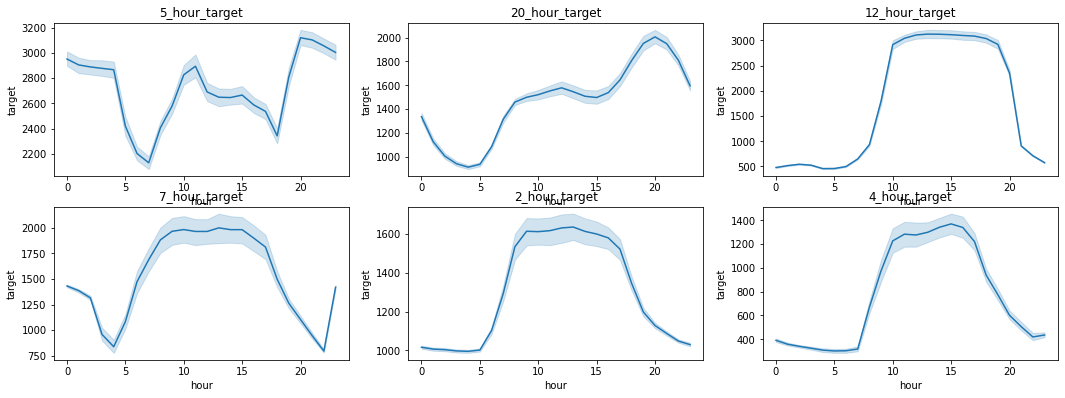

In [101]:
# 개별 건물 별 시간과 전력사용량 그래프

sample = [5, 20, 12, 7, 2, 4]
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(sample):
    plt.subplot(12, 3, i+1)
    plt.title("{}_hour_target".format(n))
    sns.lineplot(data=train.loc[train.num == n], x='hour', y='target')

In [102]:
# dataset save
train_my = train.copy()
test_my = test.copy()

# 다른 모델 만들어보기

Random Forest에 feature를 추가하지 않고, clustering만 수행하여 원래의 dataset으로 학습시켜보기

In [103]:
# 데이터 로드
train=pd.read_csv('train.csv', encoding='euc-kr')
test=pd.read_csv('test.csv', encoding='euc-kr')
submission=pd.read_csv('sample_submission.csv', encoding='euc-kr')

In [104]:
train = make_time(train)
test = make_time(test)

In [105]:
# 결측지 보간
# test에 cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [106]:
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [107]:
# date_time 제거
train.drop(['date_time'], axis=1, inplace=True)
test.drop(['date_time'], axis=1, inplace=True)

In [108]:
# dataset 합치기

X = pd.concat([train, train_cl['km_cluster']], axis=1)
y = pd.concat([test, test_cl['km_cluster']], axis=1)

In [109]:
X

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,km_cluster
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,6,1,0,0,153,2
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,6,1,1,0,153,2
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,6,1,2,0,153,2
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,6,1,3,0,153,2
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,6,1,4,0,153,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1,1,8,24,19,0,237,3
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1,1,8,24,20,0,237,3
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1,1,8,24,21,0,237,3
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1,1,8,24,22,0,237,3


In [110]:
y

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,km_cluster
0,1,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,2.0
1,1,27.6,1.4,75.3,0.0,0.0,0.0,0.0,8,25,1,1,238,2.0
2,1,27.5,1.2,76.7,0.0,0.0,0.0,0.0,8,25,2,1,238,2.0
3,1,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,2.0
4,1,26.9,1.2,79.7,0.0,0.0,0.0,0.0,8,25,4,1,238,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.6,3.6,66.0,0.0,0.5,1.0,1.0,8,31,19,0,244,3.0
10076,60,28.3,3.8,67.0,0.0,0.3,1.0,1.0,8,31,20,0,244,3.0
10077,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,21,0,244,3.0
10078,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,22,0,244,3.0


In [111]:
others = [59, 31, 33, 34, 60, 23, 32, 39, 3, 5, 9, 15]
for other, km_num in zip(others, range(4, len(others) + 4)):
    X.loc[X.num == other, 'km_cluster'] = km_num
    y.loc[y.num == other, 'km_cluster'] = km_num

In [112]:
train_cl_0 = X.loc[X.km_cluster == 0,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_1 = X.loc[X.km_cluster == 1,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_2 = X.loc[X.km_cluster == 2,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)
train_cl_3 = X.loc[X.km_cluster == 3,
                          ~X.columns.isin(['target', 'km_cluster', 'date_time'])].reset_index(drop=True)

# 별도 모델링
# 건물별로 모델링을 할 때는 단일 값인 cooler, solar, num을 제거합니다.
for i in range(4, len(others) + 4):
    globals()['train_cl_{}'.format(i)] = X.loc[X.km_cluster == i,
                                               ~X.columns.isin(['target', 'km_cluster', 'date_time', 'cooler', 'solar', 'num'])].reset_index(drop=True)

In [113]:
train_cl_0_y = X.loc[X.km_cluster == 0, 'target'].reset_index(drop=True)
train_cl_1_y = X.loc[X.km_cluster == 1, 'target'].reset_index(drop=True)
train_cl_2_y = X.loc[X.km_cluster == 2, 'target'].reset_index(drop=True)
train_cl_3_y = X.loc[X.km_cluster == 3, 'target'].reset_index(drop=True)

# 별도 모델링
for i in range(4, len(others) + 4):
    globals()['train_cl_{}_y'.format(i)] = X.loc[X.km_cluster == i, 'target'].reset_index(drop=True)

In [114]:
test_cl_0 = y.loc[y.km_cluster == 0, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_1 = y.loc[y.km_cluster == 1, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_2 = y.loc[y.km_cluster == 2, ~y.columns.isin(['km_cluster', 'date_time'])]
test_cl_3 = y.loc[y.km_cluster == 3, ~y.columns.isin(['km_cluster', 'date_time'])]

# 별도 모델링
# 건물별로 모델링을 할 때는 단일 값인 cooler, solar, num을 제거합니다.
for i in range(4, len(others) + 4):
    globals()['test_cl_{}'.format(i)] = y.loc[y.km_cluster == i, ~y.columns.isin(['km_cluster', 'date_time', 'cooler', 'solar', 'num'])]

In [115]:
train_x_sets = [train_cl_0, train_cl_1, train_cl_2, train_cl_3,
               train_cl_4, train_cl_5, train_cl_6, train_cl_7,
               train_cl_8, train_cl_9, train_cl_10, train_cl_11,
               train_cl_12, train_cl_13, train_cl_14, train_cl_15]
train_y_sets = [train_cl_0_y, train_cl_1_y, train_cl_2_y, train_cl_3_y,
               train_cl_4_y, train_cl_5_y, train_cl_6_y, train_cl_7_y,
               train_cl_8_y, train_cl_9_y, train_cl_10_y, train_cl_11_y,
               train_cl_12_y, train_cl_13_y, train_cl_14_y, train_cl_15_y]
test_x_sets = [test_cl_0, test_cl_1, test_cl_2, test_cl_3,
              test_cl_4, test_cl_5, test_cl_6, test_cl_7,
              test_cl_8, test_cl_9, test_cl_10, test_cl_11,
              test_cl_12, test_cl_13, test_cl_14, test_cl_15]

In [116]:
train_cl_0

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear
0,19,18.3,2.5,94.0,0.0,0.0,0,0,6,1,0,0,153
1,19,18.8,2.3,89.0,0.0,0.0,0,0,6,1,1,0,153
2,19,19.0,3.2,86.0,0.0,0.0,0,0,6,1,2,0,153
3,19,19.0,4.1,85.0,0.0,0.0,0,0,6,1,3,0,153
4,19,18.9,3.9,87.0,0.0,0.0,0,0,6,1,4,0,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,51,29.4,3.4,66.0,0.0,0.2,0,1,8,24,19,0,237
12236,51,28.7,1.9,69.0,0.0,0.0,0,1,8,24,20,0,237
12237,51,28.3,1.1,71.0,0.0,0.0,0,1,8,24,21,0,237
12238,51,28.3,2.4,72.0,0.0,0.0,0,1,8,24,22,0,237


In [117]:
test_cl_0

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear
3024,19,26.7,0.9,87.0,0.0,0.0,0.0,0.0,8,25,0,1,238
3025,19,26.5,0.9,87.0,0.0,0.0,0.0,0.0,8,25,1,1,238
3026,19,26.4,0.9,87.0,0.0,0.0,0.0,0.0,8,25,2,1,238
3027,19,26.2,0.9,87.0,0.0,0.0,0.0,0.0,8,25,3,1,238
3028,19,26.1,0.8,86.7,0.0,0.0,0.0,0.0,8,25,4,1,238
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,51,28.2,2.8,72.7,0.0,0.8,0.0,1.0,8,31,19,0,244
8564,51,27.7,2.6,73.3,0.0,0.4,0.0,1.0,8,31,20,0,244
8565,51,27.1,2.4,74.0,0.0,0.0,0.0,1.0,8,31,21,0,244
8566,51,27.3,2.1,74.0,0.0,0.0,0.0,1.0,8,31,22,0,244


In [118]:
preds = []
fe = []
#oob = []
for x, y, t in zip(train_x_sets, train_y_sets, test_x_sets):
    rf = RandomForestRegressor(random_state=42,
                               #oob_score=True,
                               n_estimators=200,
                               n_jobs = -1)
    rf.fit(x, y)
    pred = rf.predict(t)
    preds.append(pred)
    fe.append(rf.feature_importances_)
    #oob.append(rf.oob_score_)

In [119]:
pred_set = []
for te, p in zip(test_x_sets, preds):
    te['pred'] = p
    pred_set.append(te)

In [120]:
pred_set = pd.concat(pred_set).sort_index()

In [121]:
sub.answer = pred_set.pred

In [122]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8676.30852
1,1 2020-08-25 01,8671.50360
2,1 2020-08-25 02,8668.37052
3,1 2020-08-25 03,8662.87224
4,1 2020-08-25 04,8656.04232
...,...,...
10075,60 2020-08-31 19,4074.13584
10076,60 2020-08-31 20,3988.81368
10077,60 2020-08-31 21,3788.33760
10078,60 2020-08-31 22,3551.65560


In [123]:
# 4번째 저장
sub.to_csv("/content/drive/MyDrive/dataSience/energy/data/testScore_original.csv", index=False)

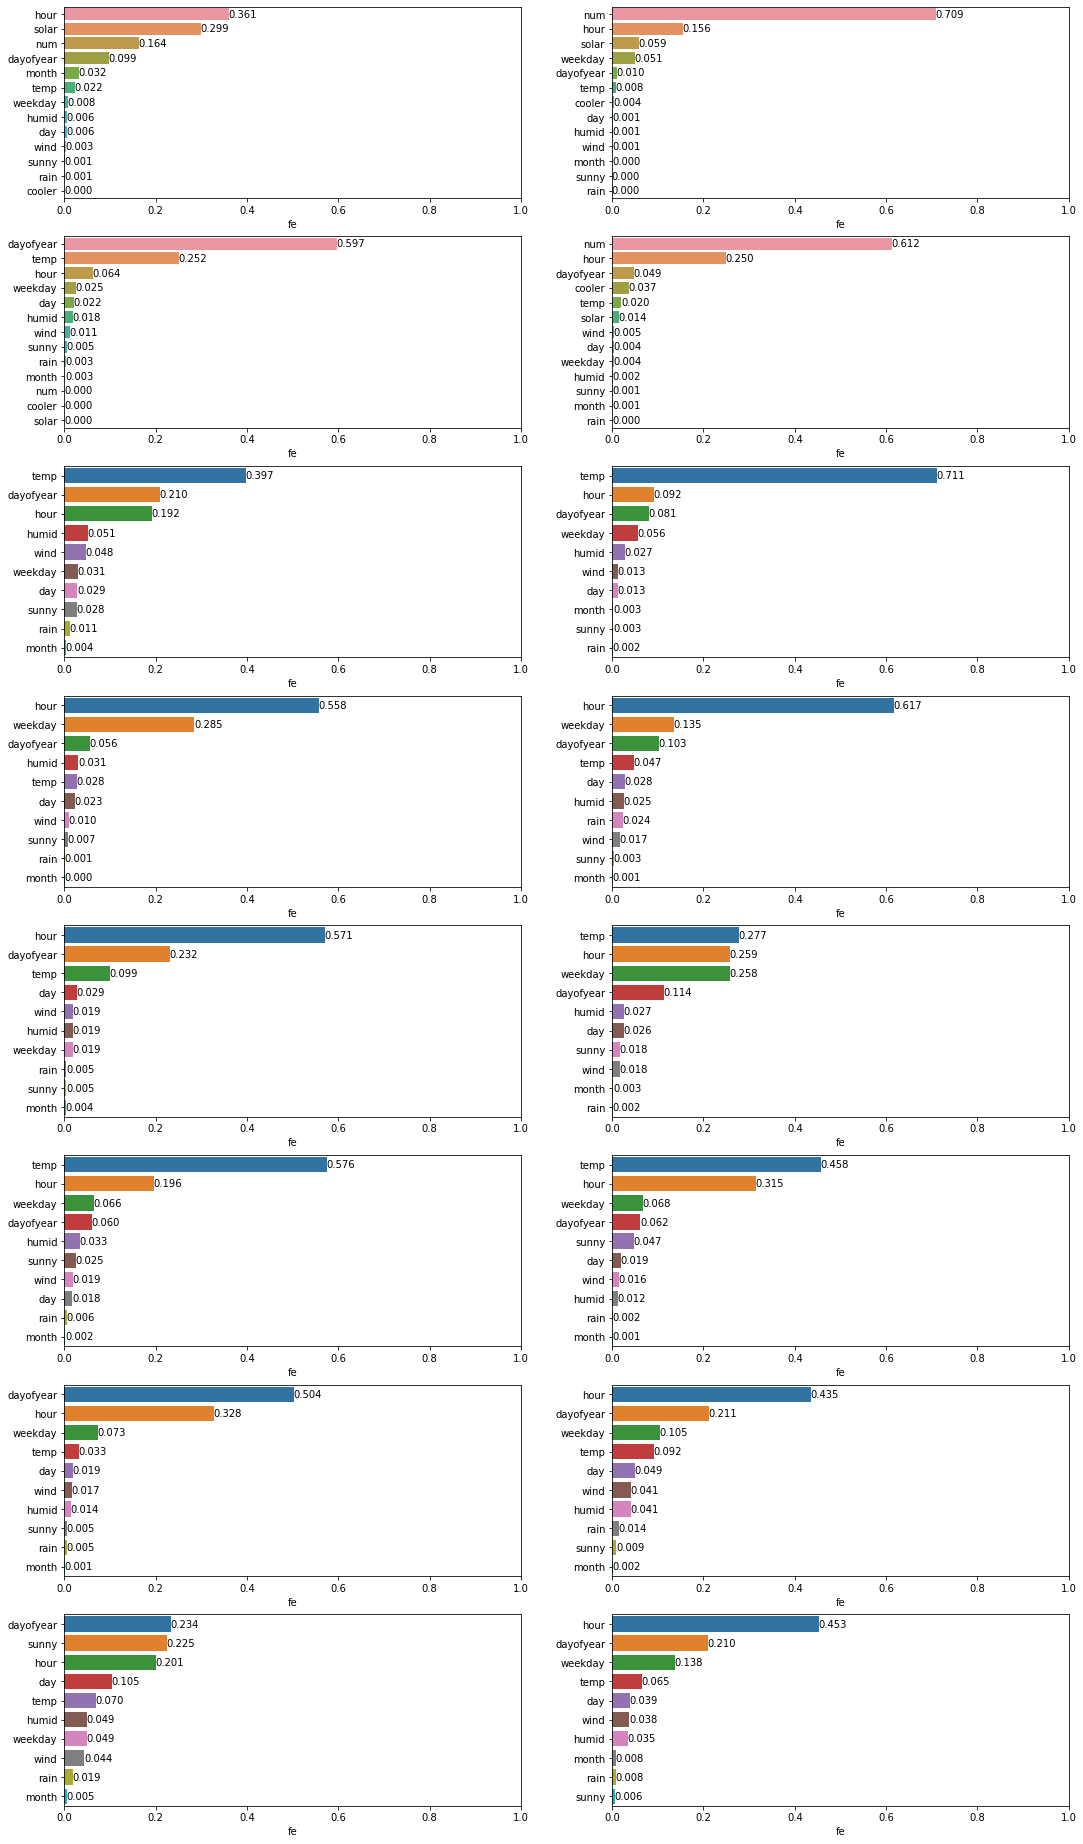

In [124]:
fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(range(len(X.km_cluster.unique()))):
    plt.subplot(12, 2, i+1)
    if len(fe[i]) == 13:
        fe_avg = pd.DataFrame(fe[i], index=train_cl_0.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
    else:
        fe_avg = pd.DataFrame(fe[i], index=train_cl_5.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
        
    plt.xlim(right=1)
    plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

    # Annotate every single Bar with its value, based on it's width            
    for bar in plots.patches:
        width = bar.get_width()
        plt.text(0.03 + bar.get_width(),
                 bar.get_y() + 0.5 * bar.get_height(),
                 '{:.3f}'.format(width),
                 ha='center', va='center')

# XGBOOST model

In [125]:
train = train_my.copy
test = test_my.copy()

In [126]:
# feature 추가한 train/test set 불러오기
train_x_sets = my_train_x_sets.copy()
train_y_sets = my_train_y_sets.copy()
test_x_sets = my_test_x_sets.copy()

In [127]:
train_x_sets[0]

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat
0,19,18.3,2.5,94.0,0.0,0.0,0,0,6,1,0,0,153,0,-7.7,-28.886111,64.71098,1
1,19,18.8,2.3,89.0,0.0,0.0,0,0,6,1,1,0,153,0,-14.9,-28.886111,65.36568,1
2,19,19.0,3.2,86.0,0.0,0.0,0,0,6,1,2,0,153,0,-21.9,-28.886111,65.56860,1
3,19,19.0,4.1,85.0,0.0,0.0,0,0,6,1,3,0,153,0,-28.9,-28.886111,65.52350,1
4,19,18.9,3.9,87.0,0.0,0.0,0,0,6,1,4,0,153,0,-36.0,-28.886111,65.44657,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,51,29.4,3.4,66.0,0.0,0.2,0,1,8,24,19,0,237,0,43.7,-21.280556,79.88596,3
12236,51,28.7,1.9,69.0,0.0,0.0,0,1,8,24,20,0,237,0,47.3,-21.280556,79.28497,3
12237,51,28.3,1.1,71.0,0.0,0.0,0,1,8,24,21,0,237,0,48.7,-21.280556,78.96207,3
12238,51,28.3,2.4,72.0,0.0,0.0,0,1,8,24,22,0,237,0,48.4,-21.280556,79.09924,3


In [128]:
train_y_sets[0]

0         640.062
1         540.270
2         494.262
3         471.906
4         472.878
           ...   
12235    2909.358
12236    2934.954
12237    2780.406
12238    2529.468
12239    2181.978
Name: target, Length: 12240, dtype: float64

In [129]:
test_x_sets[0]

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,THI_cat,pred
3024,19,26.7,0.9,87.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0,0.7,27.391667,78.482710,3,923.39676
3025,19,26.5,0.9,87.0,0.0,0.0,0.0,0.0,8,25,1,1,238,0,1.2,27.391667,78.148450,3,777.10752
3026,19,26.4,0.9,87.0,0.0,0.0,0.0,0.0,8,25,2,1,238,0,1.6,27.391667,77.981320,3,703.94265
3027,19,26.2,0.9,87.0,0.0,0.0,0.0,0.0,8,25,3,1,238,0,1.8,27.391667,77.647060,3,669.32973
3028,19,26.1,0.8,86.7,0.0,0.0,0.0,0.0,8,25,4,1,238,0,1.9,27.391667,77.445313,3,658.47168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,51,28.2,2.8,72.7,0.0,0.8,0.0,1.0,8,31,19,0,244,0,18.1,2.800000,79.042286,3,2516.76720
8564,51,27.7,2.6,73.3,0.0,0.4,0.0,1.0,8,31,20,0,244,0,20.9,2.800000,78.356159,3,2521.67094
8565,51,27.1,2.4,74.0,0.0,0.0,0.0,1.0,8,31,21,0,244,0,22.6,2.800000,77.522460,3,2522.03787
8566,51,27.3,2.1,74.0,0.0,0.0,0.0,1.0,8,31,22,0,244,0,24.0,2.800000,77.830980,3,2459.46132


In [130]:
# THI_cat drop

for i in range(0, 16):
  train_x_sets[i].drop(['THI_cat'], axis=1, inplace=True)

In [131]:
train_y_sets[2]

0       8179.056
1       8135.640
2       8107.128
3       8048.808
4       8043.624
          ...   
2035    8714.952
2036    8740.224
2037    8730.504
2038    8725.968
2039    8705.232
Name: target, Length: 2040, dtype: float64

In [132]:
"""for i in range(0, 16):
    train_y_sets[i].drop(['pred'], axis=1, inplace=True)"""

"for i in range(0, 16):\n    train_y_sets[i].drop(['pred'], axis=1, inplace=True)"

In [133]:
for i in range(0, 16):
  test_x_sets[i].drop(['THI_cat', 'pred'], axis=1, inplace=True)

In [134]:
"""for i in range(0, 16):
  test_x_sets[i].drop(['pred'], axis=1, inplace=True)"""

"for i in range(0, 16):\n  test_x_sets[i].drop(['pred'], axis=1, inplace=True)"

In [135]:
test_x_sets[0]

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI
3024,19,26.7,0.9,87.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0,0.7,27.391667,78.482710
3025,19,26.5,0.9,87.0,0.0,0.0,0.0,0.0,8,25,1,1,238,0,1.2,27.391667,78.148450
3026,19,26.4,0.9,87.0,0.0,0.0,0.0,0.0,8,25,2,1,238,0,1.6,27.391667,77.981320
3027,19,26.2,0.9,87.0,0.0,0.0,0.0,0.0,8,25,3,1,238,0,1.8,27.391667,77.647060
3028,19,26.1,0.8,86.7,0.0,0.0,0.0,0.0,8,25,4,1,238,0,1.9,27.391667,77.445313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,51,28.2,2.8,72.7,0.0,0.8,0.0,1.0,8,31,19,0,244,0,18.1,2.800000,79.042286
8564,51,27.7,2.6,73.3,0.0,0.4,0.0,1.0,8,31,20,0,244,0,20.9,2.800000,78.356159
8565,51,27.1,2.4,74.0,0.0,0.0,0.0,1.0,8,31,21,0,244,0,22.6,2.800000,77.522460
8566,51,27.3,2.1,74.0,0.0,0.0,0.0,1.0,8,31,22,0,244,0,24.0,2.800000,77.830980


In [136]:
train_x_sets[1]

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI
0,2,18.3,2.5,94.0,0.0,0.0,1,0,6,1,0,0,153,0,-7.7,-28.886111,64.71098
1,2,18.8,2.3,89.0,0.0,0.0,1,0,6,1,1,0,153,0,-14.9,-28.886111,65.36568
2,2,19.0,3.2,86.0,0.0,0.0,1,0,6,1,2,0,153,0,-21.9,-28.886111,65.56860
3,2,19.0,4.1,85.0,0.0,0.0,1,0,6,1,3,0,153,0,-28.9,-28.886111,65.52350
4,2,18.9,3.9,87.0,0.0,0.0,1,0,6,1,4,0,153,0,-36.0,-28.886111,65.44657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61195,58,29.4,3.4,66.0,0.0,0.2,1,0,8,24,19,0,237,0,43.7,-21.280556,79.88596
61196,58,28.7,1.9,69.0,0.0,0.0,1,0,8,24,20,0,237,0,47.3,-21.280556,79.28497
61197,58,28.3,1.1,71.0,0.0,0.0,1,0,8,24,21,0,237,0,48.7,-21.280556,78.96207
61198,58,28.3,2.4,72.0,0.0,0.0,1,0,8,24,22,0,237,0,48.4,-21.280556,79.09924


In [137]:
train_x_sets[15]

,temp,wind,humid,rain,sunny,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI
0,17.0,2.0,100.0,1.1,0.0,6,1,0,0,153,0,-9.0,-42.052778,62.60000
1,17.2,2.3,99.0,0.1,0.0,6,1,1,0,153,0,-17.8,-42.052778,62.93272
2,17.2,3.7,98.0,0.0,0.0,6,1,2,0,153,0,-26.6,-42.052778,62.90544
3,16.7,3.1,99.0,0.0,0.0,6,1,3,0,153,0,-35.9,-42.052778,62.03767
4,16.9,3.5,98.0,0.0,0.0,6,1,4,0,153,0,-45.0,-42.052778,62.37138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,29.2,1.0,72.0,0.0,0.6,8,24,19,0,237,0,46.9,-20.012500,80.46976
2036,28.0,0.1,79.0,0.0,0.0,8,24,20,0,237,0,48.2,-20.012500,79.58180
2037,27.6,0.1,82.0,0.0,0.0,8,24,21,0,237,0,48.2,-20.012500,79.33568
2038,27.5,0.4,84.0,0.0,0.0,8,24,22,0,237,0,46.7,-20.012500,79.43200


In [138]:
train_y_sets[15]

0       2392.254000
1       2373.786000
2       2139.534000
3       2092.472325
4       1610.928000
           ...     
2035    2062.422000
2036    2041.362000
2037    2339.766000
2038    2320.164000
2039    3014.010000
Name: target, Length: 2040, dtype: float64

In [139]:
test_x_sets[15]

,temp,wind,humid,rain,sunny,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI
2352,27.4,1.1,83.0,0.0,0.0,8,25,0,1,238,0,1.4,30.033333,79.139580
2353,26.7,1.0,86.3,0.0,0.0,8,25,1,1,238,0,2.1,30.033333,78.397779
2354,26.1,0.9,89.7,0.0,0.0,8,25,2,1,238,0,2.2,30.033333,77.791483
2355,25.4,0.8,93.0,0.0,0.0,8,25,3,1,238,0,1.6,30.033333,76.960780
2356,25.3,1.0,93.3,0.0,0.0,8,25,4,1,238,0,0.9,30.033333,76.819951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,29.0,3.3,73.0,0.0,0.7,8,31,19,0,244,0,33.5,16.112500,80.309300
2516,28.3,2.8,76.0,0.0,0.4,8,31,20,0,244,0,35.3,16.112500,79.647920
2517,27.7,2.2,79.0,0.0,0.1,8,31,21,0,244,0,35.8,16.112500,79.104170
2518,27.0,1.5,83.7,0.0,0.1,8,31,22,0,244,0,35.0,16.112500,78.573910


In [140]:
from xgboost import XGBRegressor

preds = []
fe = []
#oob = []
for x, y, t in zip(train_x_sets, train_y_sets, test_x_sets):
    xgb = XGBRegressor(learning_rate=0.01,
                     objective='reg:squarederror',random_state=42) 

    xgb.fit(x, y)
    pred = xgb.predict(t)
    preds.append(pred)
    fe.append(xgb.feature_importances_)
    #oob.append(xgb.oob_score_)

In [141]:
pred_set = []
for te, p in zip(test_x_sets, preds):
    te['pred'] = p
    pred_set.append(te)

In [142]:
pred_set = pd.concat(pred_set).sort_index()

In [143]:
sub.answer = pred_set.pred

In [144]:
sub

,num_date_time,answer
0,1 2020-08-25 00,5418.984375
1,1 2020-08-25 01,5418.984375
2,1 2020-08-25 02,5418.984375
3,1 2020-08-25 03,5418.984375
4,1 2020-08-25 04,5418.984375
...,...,...
10075,60 2020-08-31 19,2495.607422
10076,60 2020-08-31 20,2493.641846
10077,60 2020-08-31 21,2412.012451
10078,60 2020-08-31 22,2329.734863


In [145]:
# 6번째 저장
sub.to_csv("/content/drive/MyDrive/dataSience/energy/data/testScore_xgb2.csv", index=False)

## random forest 모델에서, feature 중요도에 따라 일부 feature를 제거해보려고 함

In [146]:
# feature 추가한 train/test set 불러오기
train_x_sets = my_train_x_sets.copy()
train_y_sets = my_train_y_sets.copy()
test_x_sets = my_test_x_sets.copy()

In [147]:
train_x_sets[1]

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI
0,2,18.3,2.5,94.0,0.0,0.0,1,0,6,1,0,0,153,0,-7.7,-28.886111,64.71098
1,2,18.8,2.3,89.0,0.0,0.0,1,0,6,1,1,0,153,0,-14.9,-28.886111,65.36568
2,2,19.0,3.2,86.0,0.0,0.0,1,0,6,1,2,0,153,0,-21.9,-28.886111,65.56860
3,2,19.0,4.1,85.0,0.0,0.0,1,0,6,1,3,0,153,0,-28.9,-28.886111,65.52350
4,2,18.9,3.9,87.0,0.0,0.0,1,0,6,1,4,0,153,0,-36.0,-28.886111,65.44657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61195,58,29.4,3.4,66.0,0.0,0.2,1,0,8,24,19,0,237,0,43.7,-21.280556,79.88596
61196,58,28.7,1.9,69.0,0.0,0.0,1,0,8,24,20,0,237,0,47.3,-21.280556,79.28497
61197,58,28.3,1.1,71.0,0.0,0.0,1,0,8,24,21,0,237,0,48.7,-21.280556,78.96207
61198,58,28.3,2.4,72.0,0.0,0.0,1,0,8,24,22,0,237,0,48.4,-21.280556,79.09924


In [148]:
train_y_sets[0]

0         640.062
1         540.270
2         494.262
3         471.906
4         472.878
           ...   
12235    2909.358
12236    2934.954
12237    2780.406
12238    2529.468
12239    2181.978
Name: target, Length: 12240, dtype: float64

In [149]:
test_x_sets[1]

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday,CDH,mean_CDH,THI,pred
168,2,26.7,0.9,87.0,0.0,0.0,1.0,0.0,8,25,0,1,238,0,0.7,27.391667,78.482710,761.297363
169,2,26.5,0.9,87.0,0.0,0.0,1.0,0.0,8,25,1,1,238,0,1.2,27.391667,78.148450,761.297363
170,2,26.4,0.9,87.0,0.0,0.0,1.0,0.0,8,25,2,1,238,0,1.6,27.391667,77.981320,761.297363
171,2,26.2,0.9,87.0,0.0,0.0,1.0,0.0,8,25,3,1,238,0,1.8,27.391667,77.647060,743.977600
172,2,26.1,0.8,86.7,0.0,0.0,1.0,0.0,8,25,4,1,238,0,1.9,27.391667,77.445313,743.977600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9739,58,28.2,2.8,72.7,0.0,0.8,1.0,0.0,8,31,19,0,244,0,18.1,2.562500,79.042286,1101.803223
9740,58,27.7,2.6,73.3,0.0,0.4,1.0,0.0,8,31,20,0,244,0,20.9,2.562500,78.356159,1101.803223
9741,58,27.1,2.4,74.0,0.0,0.0,1.0,0.0,8,31,21,0,244,0,22.6,2.562500,77.522460,1101.803223
9742,58,25.9,2.1,81.3,0.0,0.0,1.0,0.0,8,31,22,0,244,0,22.6,2.562500,76.499233,1101.803223


In [150]:
# weekday drop

for i in range(0, 16):
  train_x_sets[i].drop(['weekday'], axis=1, inplace=True)

In [151]:
for i in range(0, 16):
  test_x_sets[i].drop(['weekday'], axis=1, inplace=True)

In [152]:
# pred drop

for i in range(0, 16):
  test_x_sets[i].drop(['pred'], axis=1, inplace=True)

In [153]:
train_x_sets[4]

,temp,wind,humid,rain,sunny,month,day,hour,dayofyear,holiday,CDH,mean_CDH,THI
0,19.8,1.2,77.0,0.0,0.0,6,1,0,153,0,-6.2,-33.337500,66.42054
1,19.6,0.7,78.0,0.0,0.0,6,1,1,153,0,-12.6,-33.337500,66.15712
2,19.5,0.1,79.0,0.0,0.0,6,1,2,153,0,-19.1,-33.337500,66.04895
3,19.0,0.2,82.0,0.0,0.0,6,1,3,153,0,-26.1,-33.337500,65.38820
4,19.1,0.1,83.0,0.0,0.0,6,1,4,153,0,-33.0,-33.337500,65.59647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,27.2,0.1,82.0,0.0,0.0,8,24,19,237,0,34.0,-38.704167,78.68696
2036,25.4,2.2,88.0,0.0,0.0,8,24,20,237,0,35.7,-38.704167,76.41848
2037,25.0,1.5,90.0,0.0,0.0,8,24,21,237,0,36.2,-38.704167,75.95500
2038,24.3,0.2,94.0,0.0,0.0,8,24,22,237,0,33.0,-38.704167,75.15458


In [154]:
train_y_sets[4]

0        572.184
1        574.128
2        910.440
3        679.104
4        683.640
          ...   
2035    1186.164
2036     929.232
2037    1003.104
2038    1110.672
2039     985.284
Name: target, Length: 2040, dtype: float64

In [155]:
test_x_sets[4]

,temp,wind,humid,rain,sunny,month,day,hour,dayofyear,holiday,CDH,mean_CDH,THI
9744,23.5,1.4,96.0,0.0,0.0,8,25,0,238,0,-2.5,-4.058333,73.941400
9745,23.2,1.0,97.0,0.0,0.0,8,25,1,238,0,-5.3,-4.058333,73.499960
9746,22.8,0.5,98.0,0.0,0.0,8,25,2,238,0,-8.5,-4.058333,72.874560
9747,22.5,0.1,99.0,0.0,0.0,8,25,3,238,0,-12.0,-4.058333,72.420250
9748,22.6,0.2,99.0,0.0,0.0,8,25,4,238,0,-15.4,-4.058333,72.599260
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,24.6,1.2,81.0,0.0,0.1,8,31,19,244,0,5.7,-3.762500,74.369740
9908,24.1,0.9,82.0,0.0,0.0,8,31,20,244,0,4.6,-3.762500,73.659380
9909,23.5,0.6,83.0,0.0,0.0,8,31,21,244,0,2.3,-3.762500,72.775950
9910,24.7,1.6,80.7,0.0,0.0,8,31,22,244,0,0.7,-3.762500,74.500471


In [156]:
# rain, sunny drop
for i in range(0, 16):
  train_x_sets[i].drop(['rain', 'sunny'], axis=1, inplace=True)

In [157]:
for i in range(0, 16):
  test_x_sets[i].drop(['rain', 'sunny'], axis=1, inplace=True)

In [158]:
# random forest model

preds = []
fe = []
#oob = []
for x, y, t in zip(train_x_sets, train_y_sets, test_x_sets):
    rf = RandomForestRegressor(random_state=42,
                               #oob_score=True,
                               n_estimators=200,
                               n_jobs = -1)
    rf.fit(x, y)
    pred = rf.predict(t)
    preds.append(pred)
    fe.append(rf.feature_importances_)
    #oob.append(rf.oob_score_)

In [159]:
pred_set = []
for te, p in zip(test_x_sets, preds):
    te['pred'] = p
    pred_set.append(te)

In [160]:
pred_set = pd.concat(pred_set).sort_index()

In [161]:
sub.answer = pred_set.pred

In [162]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8667.07452
1,1 2020-08-25 01,8665.87248
2,1 2020-08-25 02,8664.95232
3,1 2020-08-25 03,8651.73636
4,1 2020-08-25 04,8614.94292
...,...,...
10075,60 2020-08-31 19,4126.96512
10076,60 2020-08-31 20,4054.28112
10077,60 2020-08-31 21,3801.39480
10078,60 2020-08-31 22,3590.81424


In [163]:
# 7번째 저장
sub.to_csv("/content/drive/MyDrive/dataSience/energy/data/testScore_rf_drop.csv", index=False)